# Determining Max G Force during run

- filter accel data
- length of vector
- plot alongside track velocity from a50

Using Dec 30, 2023 data since only 2 runs registered (easy):

In [1]:
from load import load_2023_12_30
from sync import splitTileIntoDownhillTracks, syncTile
from signal_processing import mean, variance, std, length, lowpass
import numpy as np
import matplotlib.pyplot as plt

a50_2023_12_30, a50_all_2023_12_30, f6p_2023_12_30, tile_2023_12_30 = load_2023_12_30()

### Sync & Split Tile into runs

In [2]:
tile_2023_12_30_sync = syncTile(
    tile=tile_2023_12_30,
    truth=a50_all_2023_12_30,
    printOutput=True,
    # use_mae=False,
    time_step_s=0.5,
    max_time_search_s=30,
    alt_step=0.25,
    min_alt_start=120,
    max_alt_search=140)

Timestamp offset: 8000
Altitude offset: 131.75


In [3]:
tile_2023_12_30_runs = splitTileIntoDownhillTracks(tile_2023_12_30_sync, a50_2023_12_30)#f6p_2023_12_30, a50_all_2023_12_30, printOutput=True, start_offset=False)
print('Run count:', len(tile_2023_12_30_runs))

93400 104900
167800 179200
185200 189200
Run count: 3


## Filtering Accelerometer

Skiing has some pretty quick motions, especially in slalom racing. However, completing fast turns down a hill is nowhere near as fast as sprinting- which is ~10Hz motion. Therfore, start with a fc of 10Hz

- fs = 100Hz
- fc = variable by filter!

The cutoff frequency was qualitatively selected, and will be explored at the final stage of this notebook once an appropriate filter is selected. For now, 5Hz and 2Hz work well for the IIR1 and Butter2 filters and show reasonable representation to eachother in terms of magnitudes.


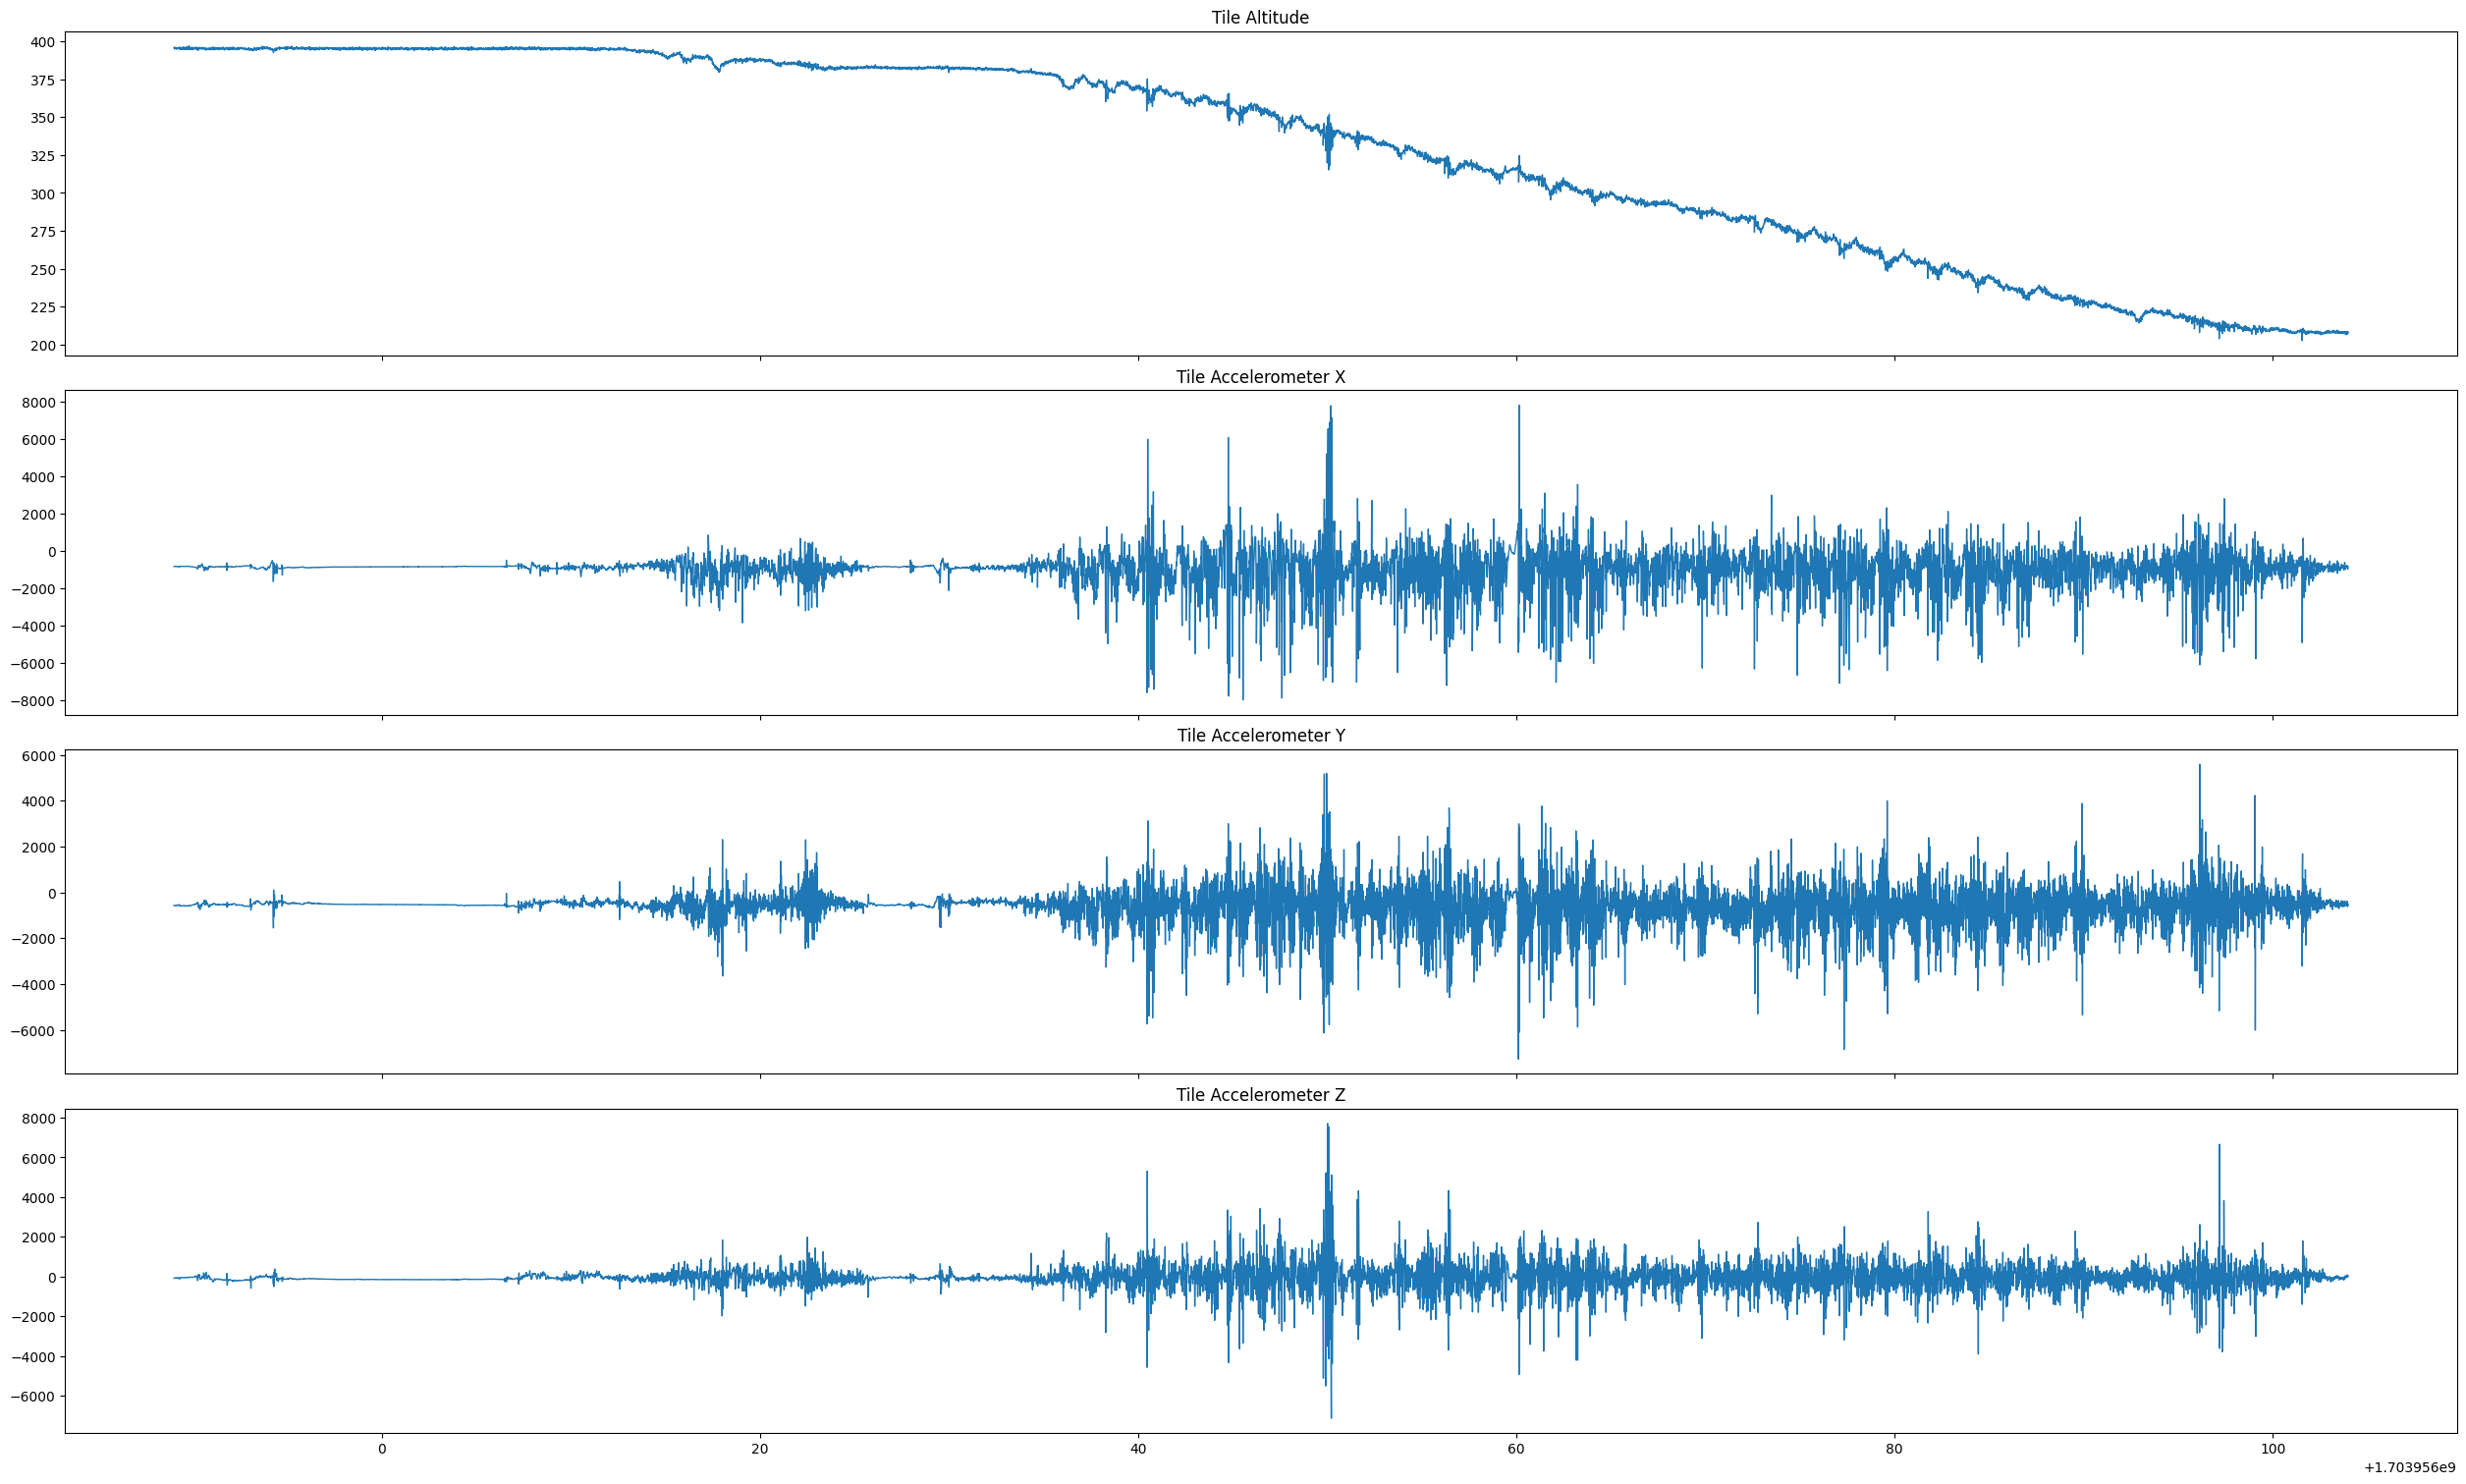

In [4]:
from plotting import plotAltAcc

run1 = tile_2023_12_30_runs[0]
run2 = tile_2023_12_30_runs[1]

_ = plotAltAcc(run1)

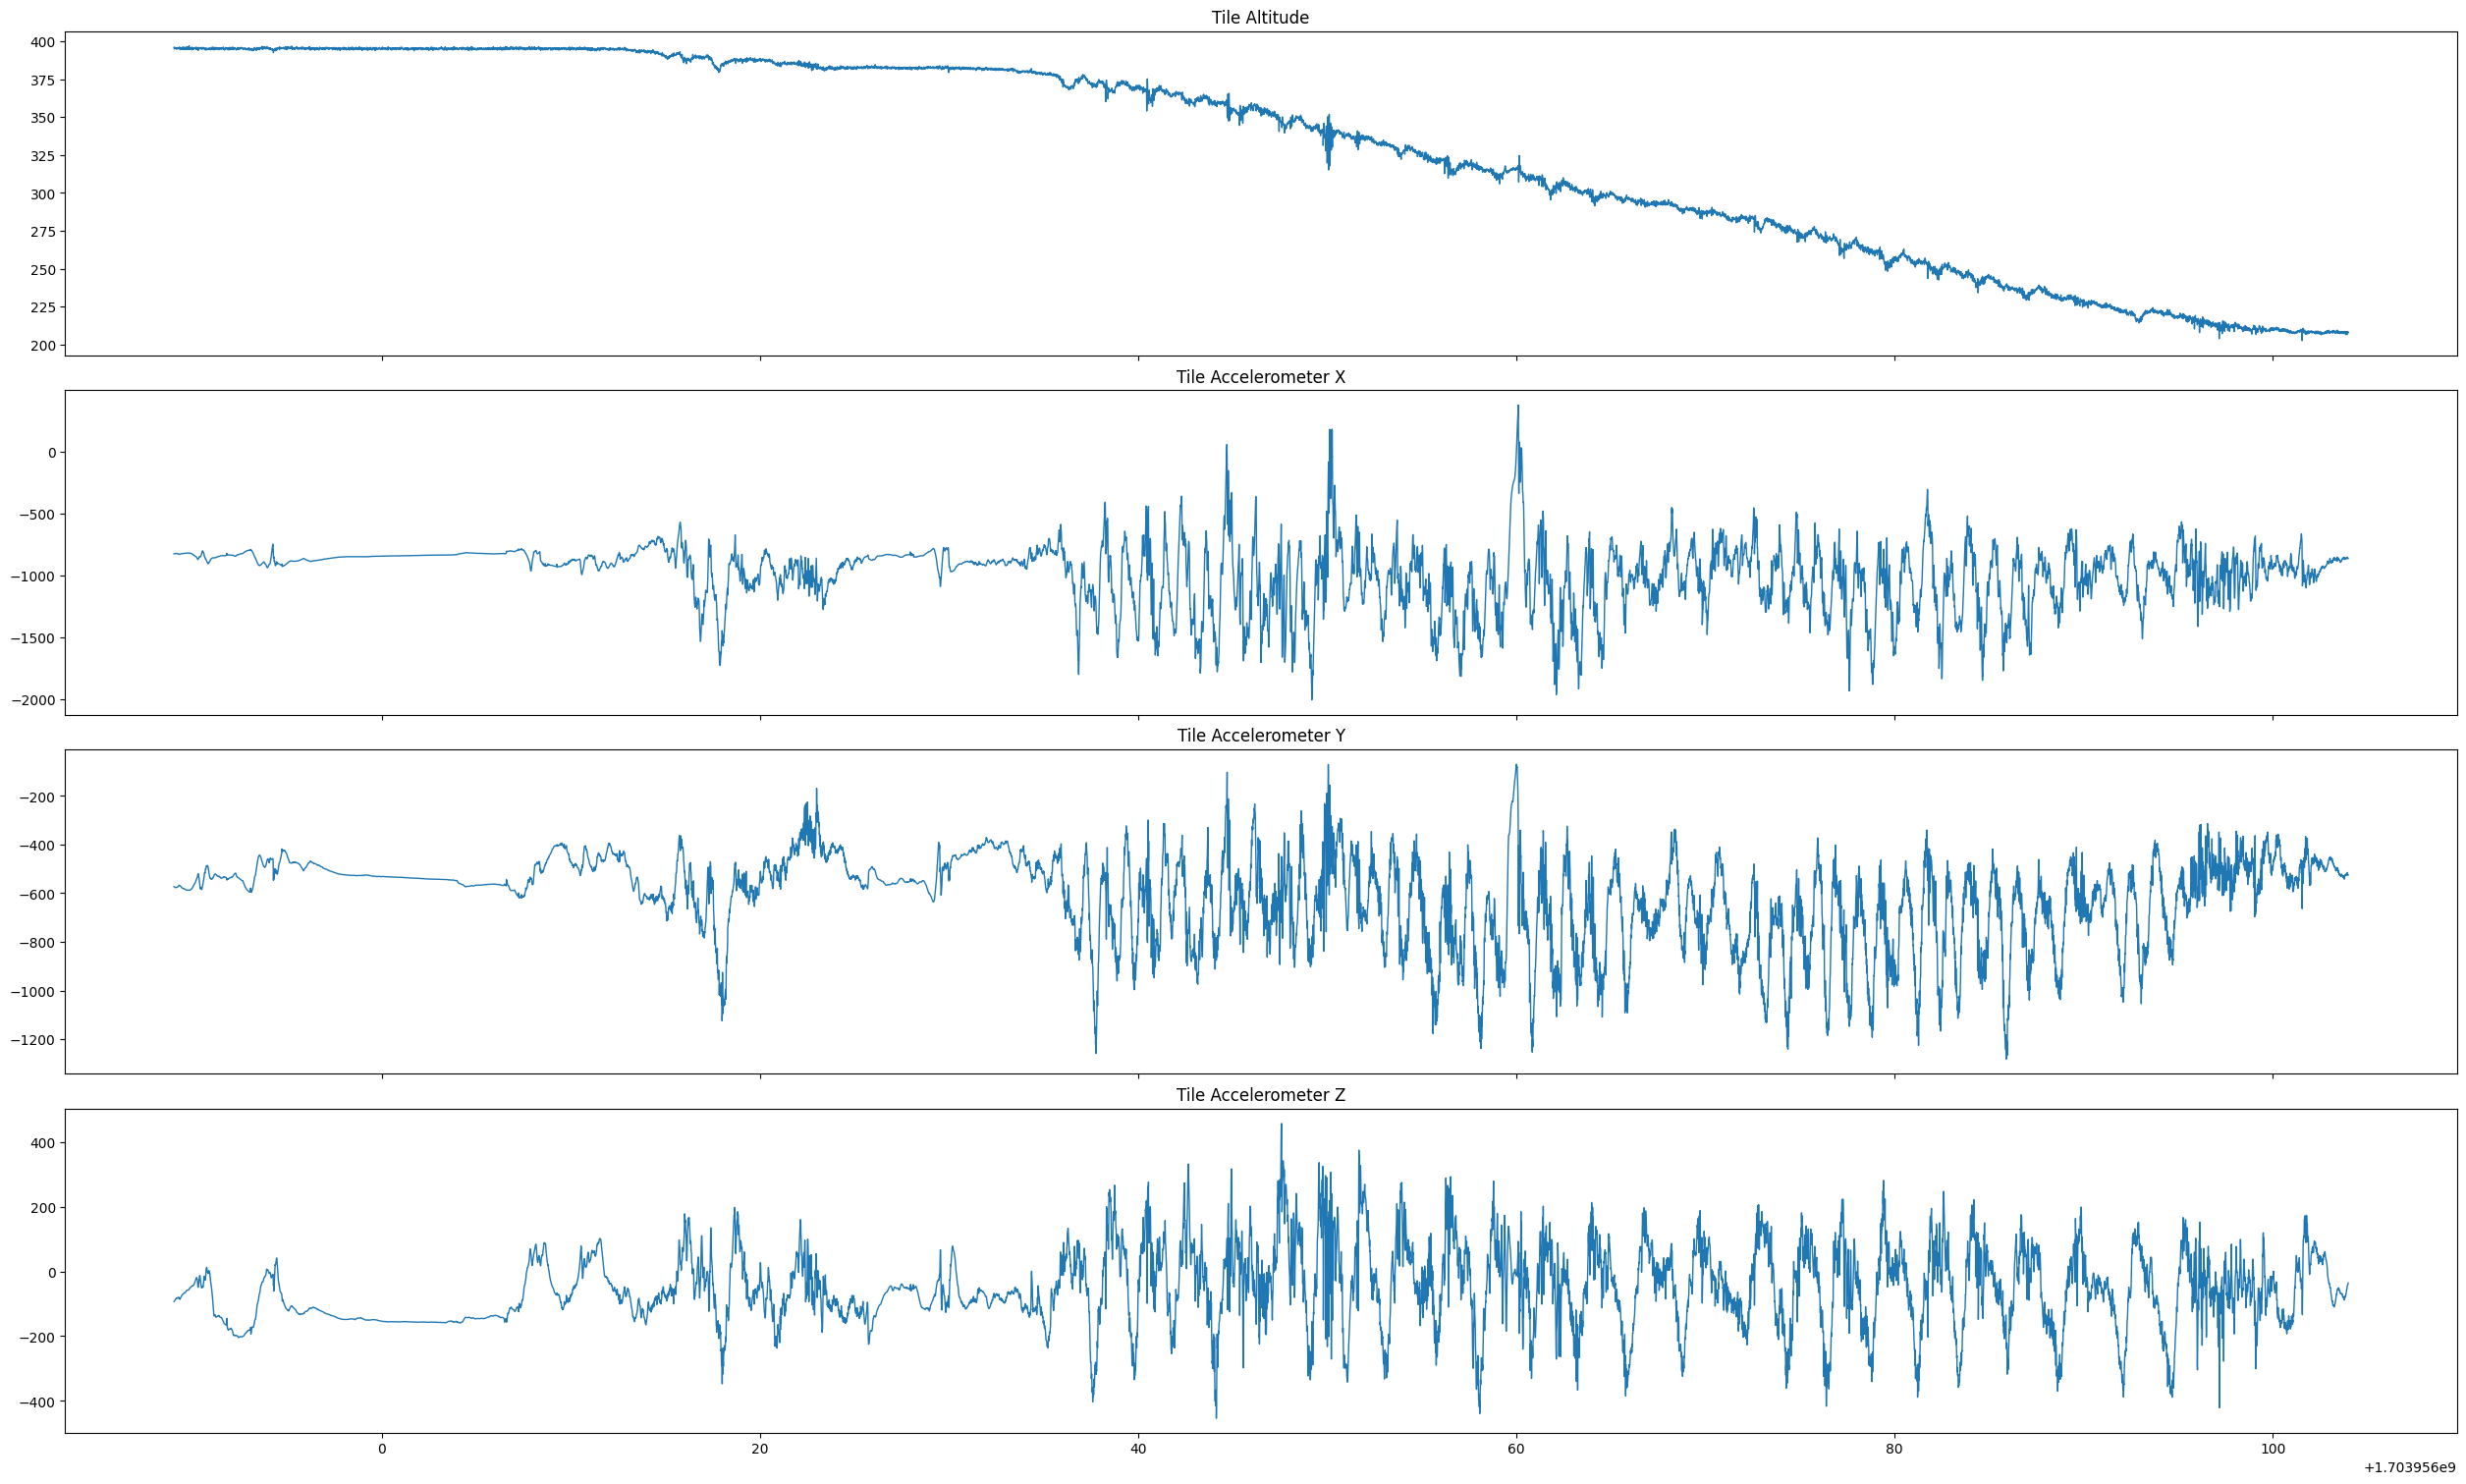

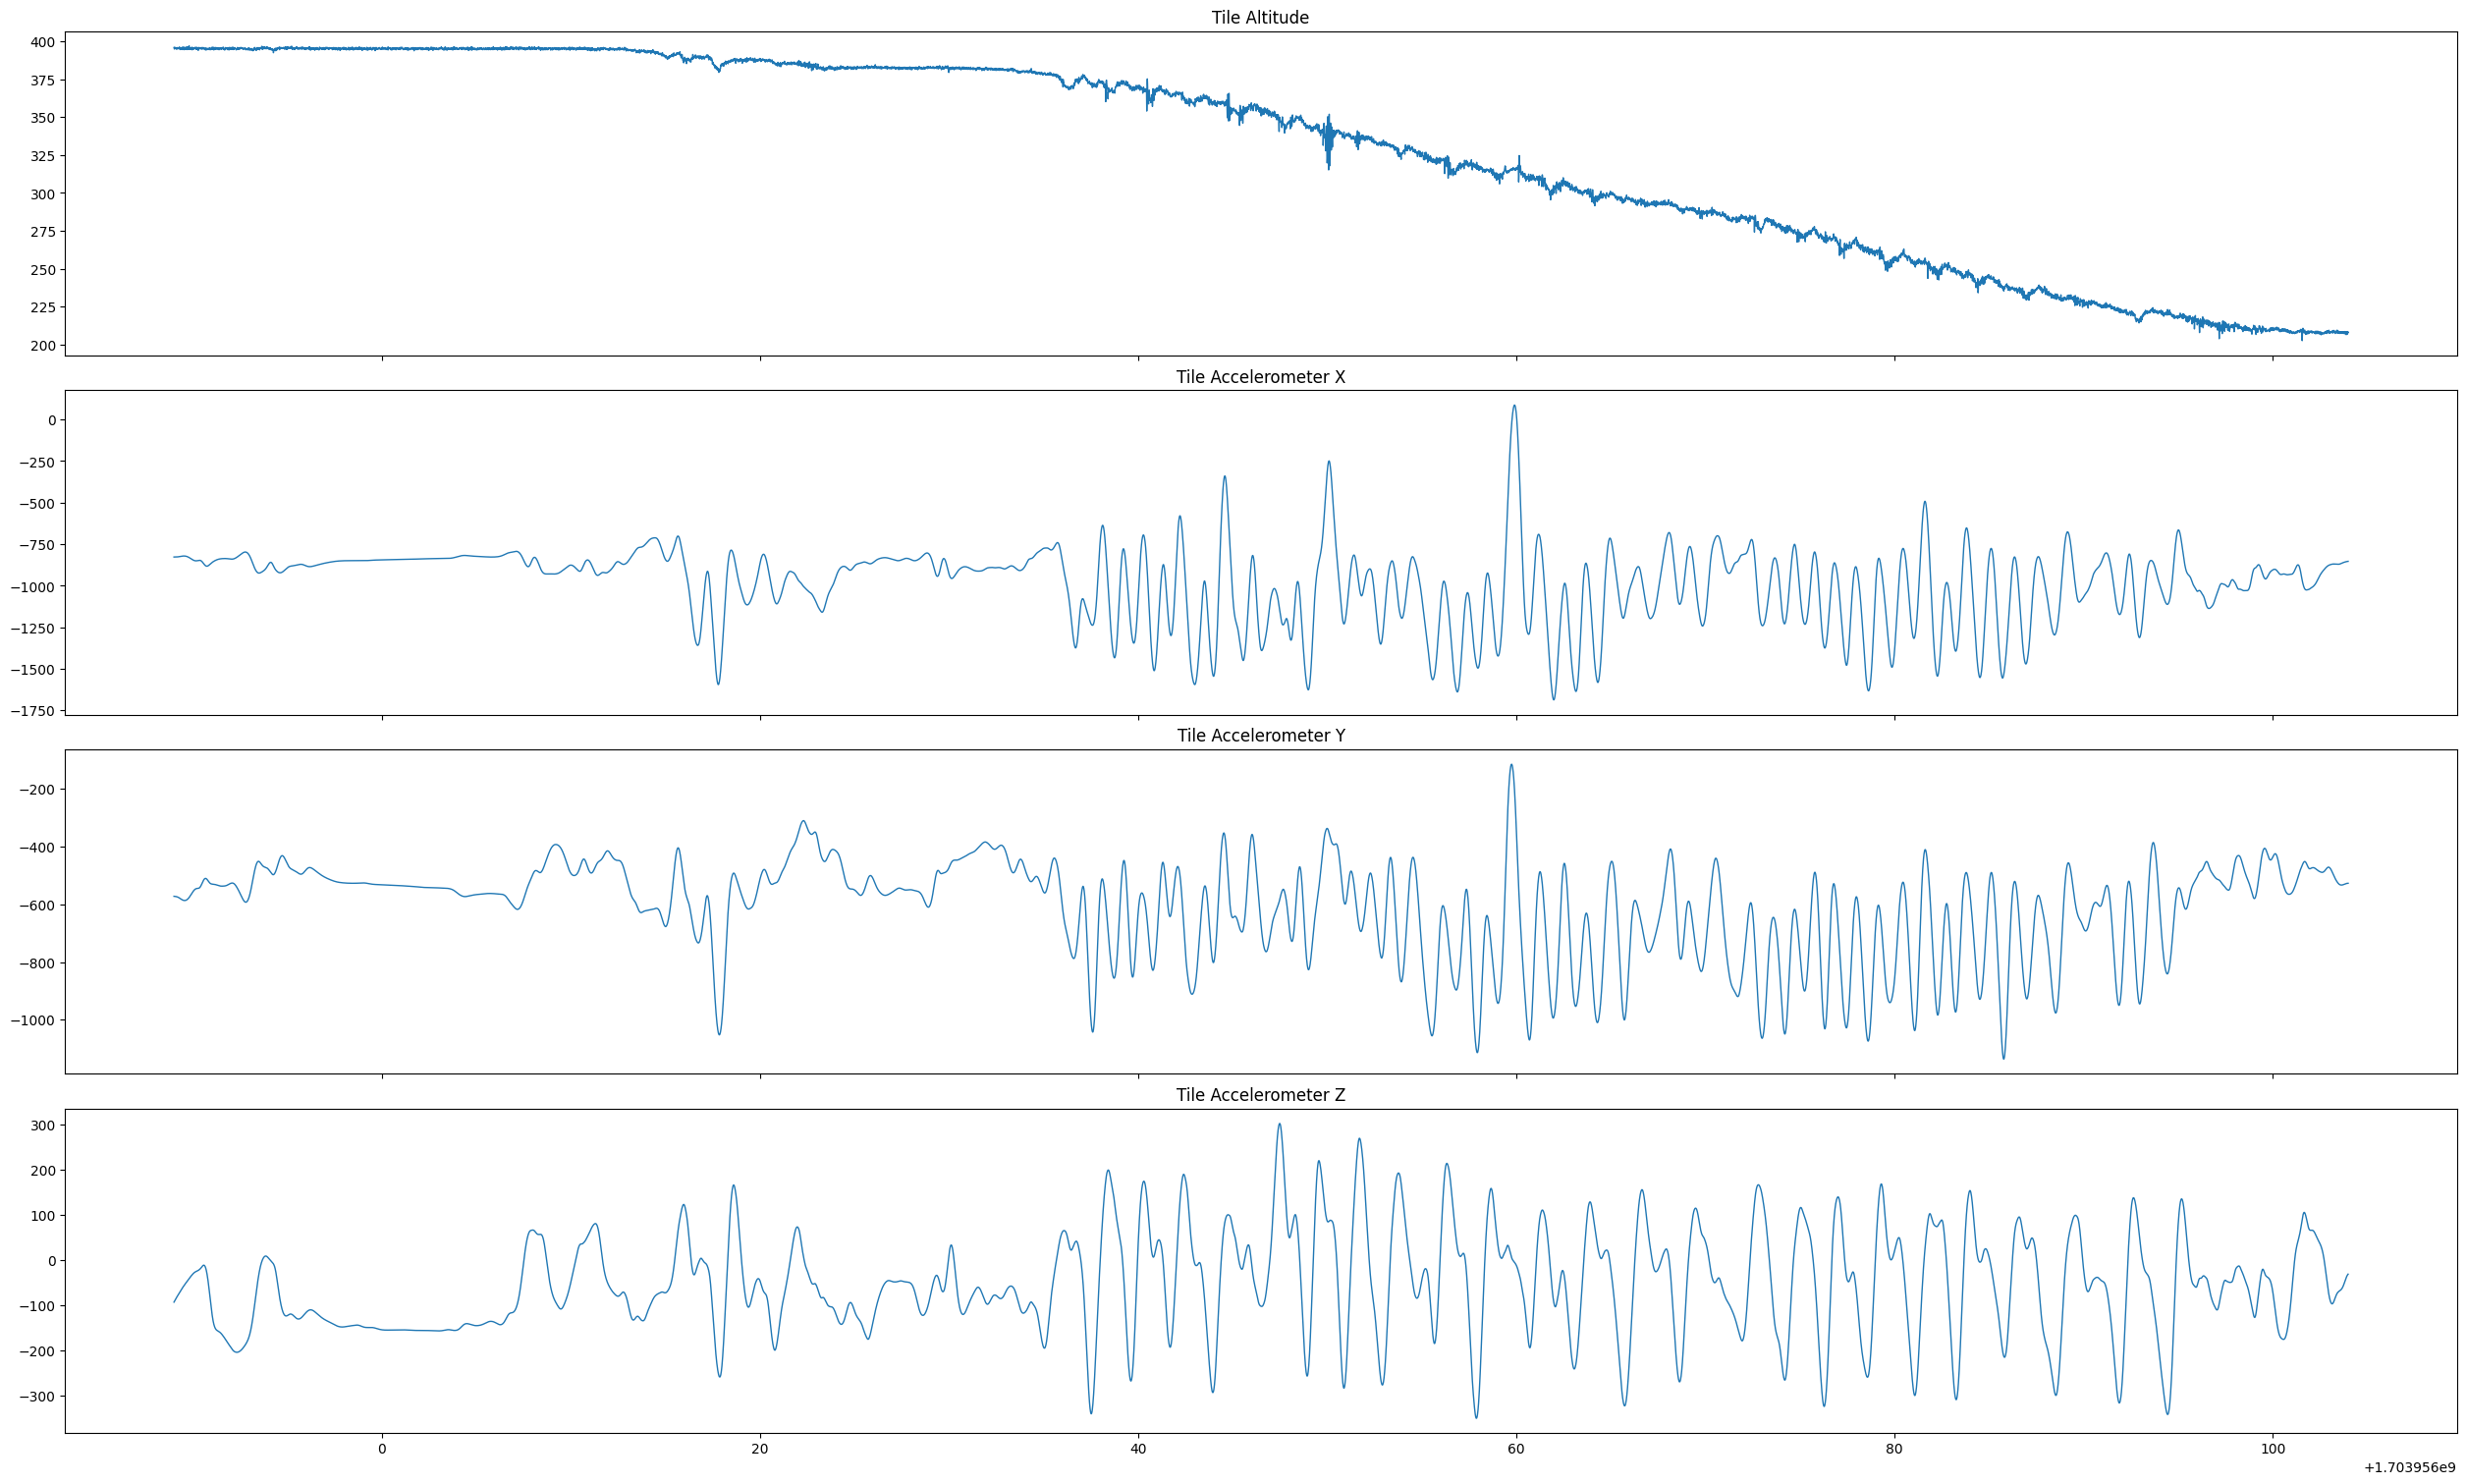

In [5]:
run1_ax_lpf = lowpass(run1.ax, 5/100, ftype='iir1')
run1_ay_lpf = lowpass(run1.ay, 5/100, ftype='iir1')
run1_az_lpf = lowpass(run1.az, 5/100, ftype='iir1')
_ = plotAltAcc(run1, run1_ax_lpf, run1_ay_lpf, run1_az_lpf)

run1_ax_lpf_b = lowpass(run1.ax, 2/100, ftype='butter2')
run1_ay_lpf_b = lowpass(run1.ay, 2/100, ftype='butter2')
run1_az_lpf_b = lowpass(run1.az, 2/100, ftype='butter2')
_ = plotAltAcc(run1, run1_ax_lpf_b, run1_ay_lpf_b, run1_az_lpf_b)

## Obtaining G-Force

G-forces were gathered based on unfiltered and filtered accelerometer signals for comparison. Filtering half of those results, we end up with a truth table of unfiltered/filtered G-force and accelerometer data (run 1).

Plots contain the statistics from the IIR1 fitler:

In [6]:
# Generic IIR ('iir1') filter
raw_mg_lpf_a = length(run1_ax_lpf, run1_ay_lpf, run1_az_lpf)
lpf_mg_raw_a = lowpass(length(run1.ax, run1.ay, run1.az), 5/100, ftype='iir1')
lpf_mg_lpf_a = lowpass(length(run1.ax_lpf(), run1.ay_lpf(), run1.az_lpf()), 5/100, ftype='iir1')
raw_mg_raw_a = length(run1.ax, run1.ay, run1.az)

mean_raw_mg_lpf_a = mean(raw_mg_lpf_a); std_raw_mg_lpf_a = std(raw_mg_lpf_a)
mean_lpf_mg_raw_a = mean(lpf_mg_raw_a); std_lpf_mg_raw_a = std(lpf_mg_raw_a)
mean_lpf_mg_lpf_a = mean(lpf_mg_lpf_a); std_lpf_mg_lpf_a = std(lpf_mg_lpf_a)
mean_raw_mg_raw_a = mean(raw_mg_raw_a); std_raw_mg_raw_a = std(raw_mg_raw_a)

# Butterworth 2nd order
raw_mg_lpf_a_b = length(run1_ax_lpf_b, run1_ay_lpf_b, run1_az_lpf_b)
lpf_mg_raw_a_b = lowpass(length(run1.ax, run1.ay, run1.az), 5/100, ftype='butter2')
lpf_mg_lpf_a_b = lowpass(length(run1_ax_lpf_b, run1_ay_lpf_b, run1_az_lpf_b), 5/100, ftype='butter2')

mean_raw_mg_lpf_a_b = mean(raw_mg_lpf_a_b); std_raw_mg_lpf_a_b = std(raw_mg_lpf_a_b)
mean_lpf_mg_raw_a_b = mean(lpf_mg_raw_a_b); std_lpf_mg_raw_a_b = std(lpf_mg_raw_a_b)
mean_lpf_mg_lpf_a_b = mean(lpf_mg_lpf_a_b); std_lpf_mg_lpf_a_b = std(lpf_mg_lpf_a_b)


def mgMeanStdLines(ax, t, mean, std):
    ax.plot(run1.time, [mean for _ in t], 'k--', label=r'$\mu$')
    ax.plot(run1.time, [mean + std for _ in t], 'g-', lw=0.25, label=r'$\mu \pm \sigma$')
    ax.plot(run1.time, [mean - std for _ in t], 'g-', lw=0.25)
    ax.plot(run1.time, [mean + 2 * std for _ in t], 'm-', lw=0.5, label=r'$\mu \pm 2\sigma$')
    ax.plot(run1.time, [mean - 2 * std for _ in t], 'm-', lw=0.5)
    ax.plot(run1.time, [mean + 3 * std for _ in t], 'r-', lw=0.75, label=r'$\mu \pm 3\sigma$')
    ax.plot(run1.time, [mean - 3 * std for _ in t], 'r-', lw=0.75)

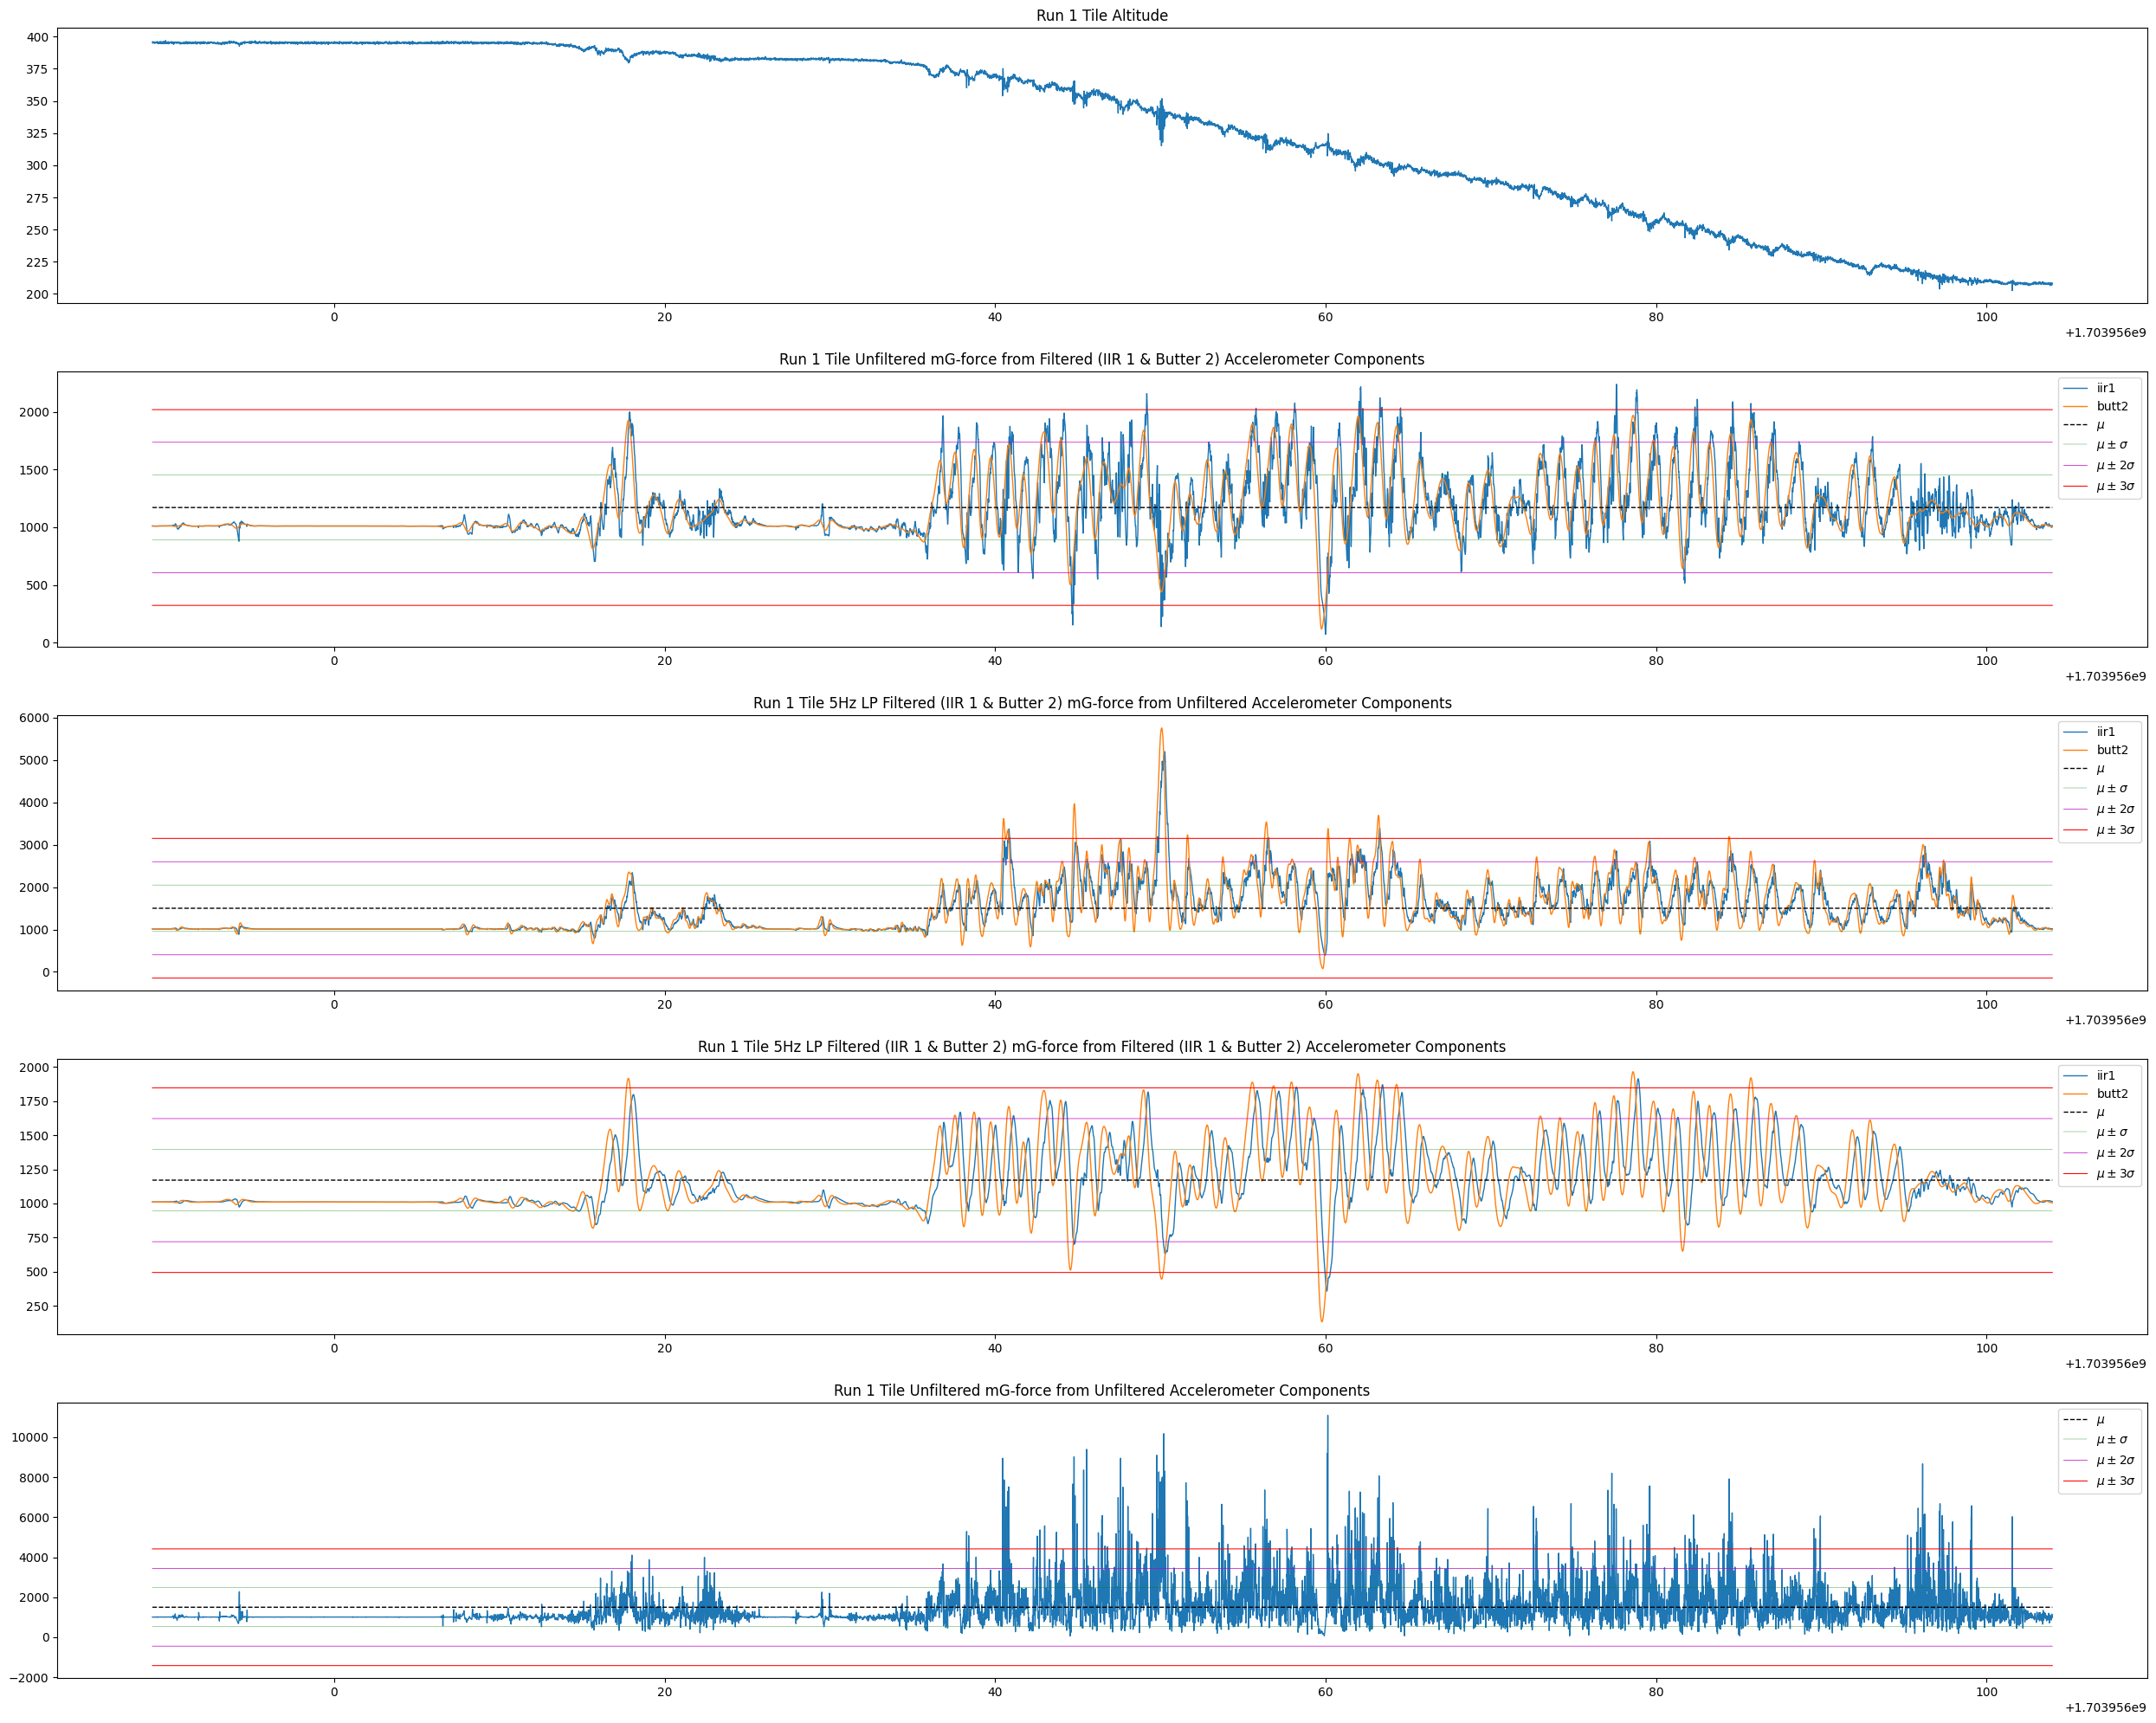

In [7]:
plt.rc('lines', linewidth=1)
_, ax = plt.subplots(5, figsize=(25, 20))
ax[0].plot(run1.time, run1.corrected_alt)
ax[0].set_title('Run 1 Tile Altitude', wrap=True)

ax[1].plot(run1.time, raw_mg_lpf_a, label='iir1')
ax[1].plot(run1.time, raw_mg_lpf_a_b, label='butt2')
ax[1].set_title('Run 1 Tile Unfiltered mG-force from Filtered (IIR 1 & Butter 2) Accelerometer Components', wrap=True)
mgMeanStdLines(ax[1], run1.time, mean_raw_mg_lpf_a, std_raw_mg_lpf_a)
ax[1].legend()

ax[2].plot(run1.time, lpf_mg_raw_a, label='iir1')
ax[2].plot(run1.time, lpf_mg_raw_a_b, label='butt2')
ax[2].set_title('Run 1 Tile 5Hz LP Filtered (IIR 1 & Butter 2) mG-force from Unfiltered Accelerometer Components', wrap=True)
mgMeanStdLines(ax[2], run1.time, mean_lpf_mg_raw_a, std_lpf_mg_raw_a)
ax[2].legend()

ax[3].plot(run1.time, lpf_mg_lpf_a, label='iir1')
ax[3].plot(run1.time, lpf_mg_lpf_a_b, label='butt2')
ax[3].set_title('Run 1 Tile 5Hz LP Filtered (IIR 1 & Butter 2) mG-force from Filtered (IIR 1 & Butter 2) Accelerometer Components', wrap=True)
mgMeanStdLines(ax[3], run1.time, mean_lpf_mg_lpf_a, std_lpf_mg_lpf_a)
ax[3].legend()

ax[4].plot(run1.time, raw_mg_raw_a)
ax[4].set_title('Run 1 Tile Unfiltered mG-force from Unfiltered Accelerometer Components', wrap=True)
mgMeanStdLines(ax[4], run1.time, mean_raw_mg_raw_a, std_raw_mg_raw_a)
ax[4].legend()

plt.tight_layout()
plt.show()

## Which Signal is True?

Comparing to the unfiltered signal, the noise is wild. The filtered signal will be good for identifying turns and moments of lower freq, but the unfiltered g-force should be used to identify impulses- which are still important.

The Butterworth signal is also reporting the filtered values earlier, since it's filtered using `filtfilt` which filters twice (once forwards, once backwards, then takes the middle).

### Max G's a Human can Take

Even at 2G's, it would feel as though I were supporting double my weight- about 400lbs, or bar squatting your weight- almost 2 plates. At 3G's, I'd feel 600lbs and would have to be able to emerge from a bar squat of 400lbs without crumpling. Based on this, selecting the filtfilt option is logical since it posts reasonable G-forces that didn't result in my demise- but still provided a realistic working weight.

#### Equating Realistic G's from Centripital Forces

These exclude force measured from gravity! Note that the tile measures all forces acting on it, so subtract gravity if you'd like to just report G's from turning.

*$r$: turn radius*

$F = \frac{mv^2}{r}$

With $W = mg$, in G's divide by the weight, $G = F / W$:

$G = \frac{mv^2}{r(mg)} = \frac{v^2}{rg}$

Assuming a turn radius of 20m, a hard turn (IBOX rossi rated radius = ~14m), G's felt at **65kph = 18mps** during that turn:

$G = \frac{18^2}{20 * 9.81} = 1.65G$

Although, you typically aren't turning at tighter 20m turns while going the max speed down the hill. Since 25m is a typical GS turn radius made in GS races, you can assume this as your smallest radius at the recorded mac velocity (if carving as hard as you can). Therefore, taking the typical max speed recorded during these ski days, of **85kph = 23.61mps** and a turning radius of **25m**:

$G = \frac{23.61^2}{25 * 9.81} = 2.27G$

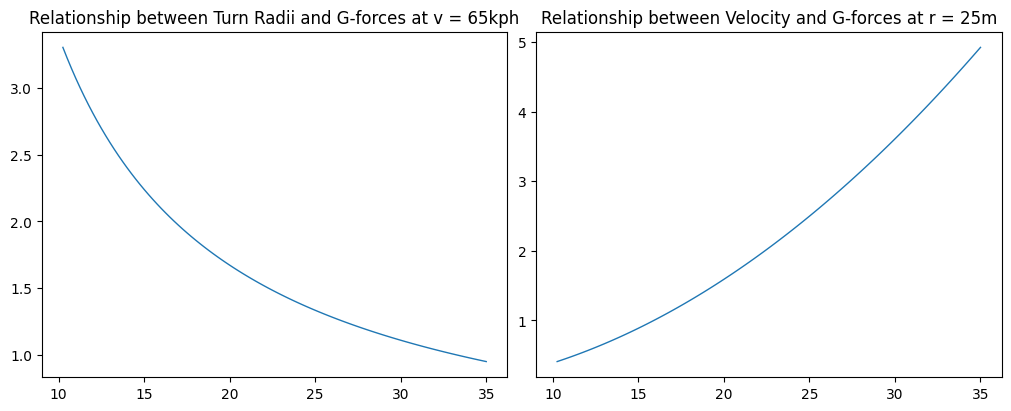

In [8]:
def gFromVelAndR(mps, r): return mps**2 / (r * 9.81)

gs = [gFromVelAndR(18, 10 + 0.25*i) for i in range(100)]

plt.rc('lines', linewidth=1)
_, ax = plt.subplots(1, 2, figsize=(10, 4), layout="constrained")
ax[0].plot([10 + 0.25*(i + 1) for i in range(100)], gs)
ax[0].set_title('Relationship between Turn Radii and G-forces at v = 65kph', wrap=True)

gs = [gFromVelAndR(10 + 0.25*i, 25) for i in range(100)]

ax[1].plot([10 + 0.25*(i + 1) for i in range(100)], gs)
ax[1].set_title('Relationship between Velocity and G-forces at r = 25m', wrap=True)
plt.show()

### Confirming the Timing of the Filtered Signals

In [9]:
min_r = [6000, 8000]

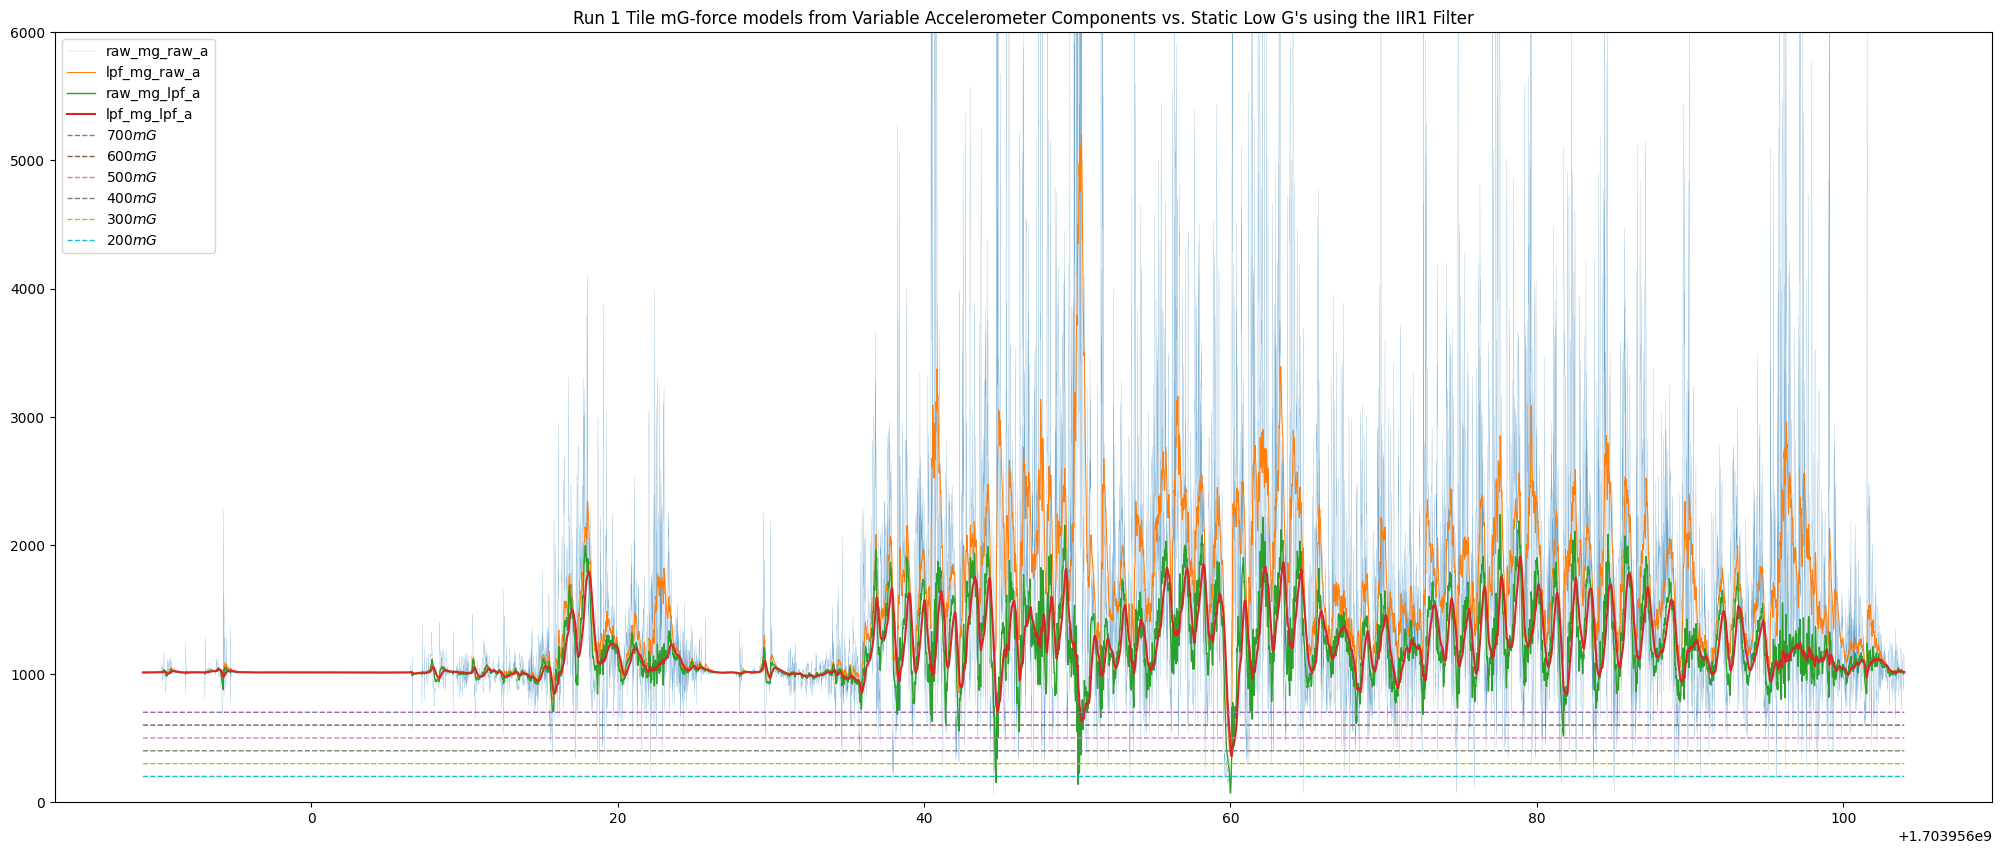

min raw_mg_raw_a: 71.61703707917552 at index: 7092
min lpf_mg_raw_a: 391.032904473478 at index: 7096
min raw_mg_lpf_a: 70.93997361482009 at index: 7100
min lpf_mg_lpf_a: 357.57456721180284 at index: 7108


In [10]:
from signal_processing import minIndex


plt.rc('lines', linewidth=1)
_, ax = plt.subplots(figsize=(25, 10))
ax.plot(run1.time, raw_mg_raw_a, label='raw_mg_raw_a', lw=0.1)
ax.plot(run1.time, lpf_mg_raw_a, label='lpf_mg_raw_a', lw=0.75)
ax.plot(run1.time, raw_mg_lpf_a, label='raw_mg_lpf_a')
ax.plot(run1.time, lpf_mg_lpf_a, label='lpf_mg_lpf_a', lw=1.5)
ax.plot(run1.time, [700 for _ in run1.time], '--', label=r'$700mG$')
ax.plot(run1.time, [600 for _ in run1.time], '--', label=r'$600mG$')
ax.plot(run1.time, [500 for _ in run1.time], '--', label=r'$500mG$')
ax.plot(run1.time, [400 for _ in run1.time], '--', label=r'$400mG$')
ax.plot(run1.time, [300 for _ in run1.time], '--', label=r'$300mG$')
ax.plot(run1.time, [200 for _ in run1.time], '--', label=r'$200mG$')
ax.set_title('Run 1 Tile mG-force models from Variable Accelerometer Components vs. Static Low G\'s using the IIR1 Filter', wrap=True)
plt.legend()
plt.ylim(0, 6000)
plt.show()

print('min raw_mg_raw_a:', min(raw_mg_raw_a[7050:7150]), 'at index:', minIndex(raw_mg_raw_a, [7050, 7150]))
print('min lpf_mg_raw_a:', min(lpf_mg_raw_a), 'at index:', minIndex(lpf_mg_raw_a))
print('min raw_mg_lpf_a:', min(raw_mg_lpf_a), 'at index:', minIndex(raw_mg_lpf_a))
print('min lpf_mg_lpf_a:', min(lpf_mg_lpf_a), 'at index:', minIndex(lpf_mg_lpf_a))

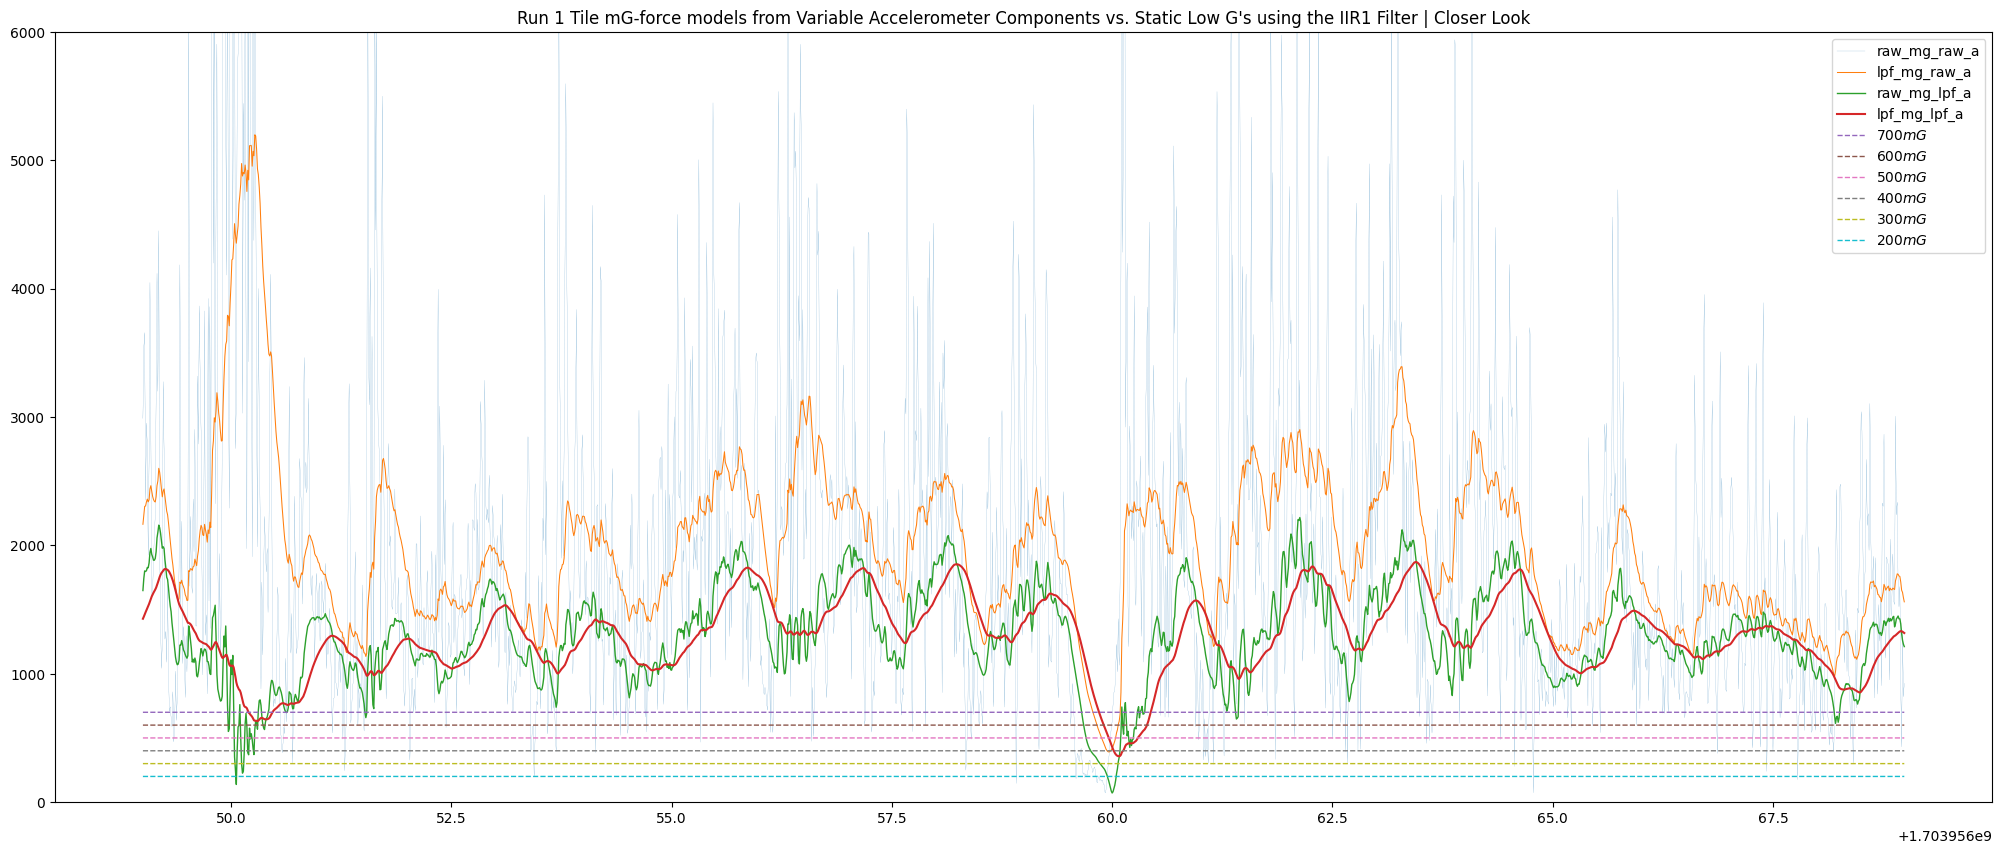

In [11]:
plt.rc('lines', linewidth=1)
_, ax = plt.subplots(figsize=(25, 10))
ax.plot(run1.time[min_r[0]:min_r[1]], raw_mg_raw_a[min_r[0]:min_r[1]], label='raw_mg_raw_a', lw=0.1)
ax.plot(run1.time[min_r[0]:min_r[1]], lpf_mg_raw_a[min_r[0]:min_r[1]], label='lpf_mg_raw_a', lw=0.75)
ax.plot(run1.time[min_r[0]:min_r[1]], raw_mg_lpf_a[min_r[0]:min_r[1]], label='raw_mg_lpf_a')
ax.plot(run1.time[min_r[0]:min_r[1]], lpf_mg_lpf_a[min_r[0]:min_r[1]], label='lpf_mg_lpf_a', lw=1.5)
ax.plot(run1.time[min_r[0]:min_r[1]], [700 for _ in run1.time[min_r[0]:min_r[1]]], '--', label=r'$700mG$')
ax.plot(run1.time[min_r[0]:min_r[1]], [600 for _ in run1.time[min_r[0]:min_r[1]]], '--', label=r'$600mG$')
ax.plot(run1.time[min_r[0]:min_r[1]], [500 for _ in run1.time[min_r[0]:min_r[1]]], '--', label=r'$500mG$')
ax.plot(run1.time[min_r[0]:min_r[1]], [400 for _ in run1.time[min_r[0]:min_r[1]]], '--', label=r'$400mG$')
ax.plot(run1.time[min_r[0]:min_r[1]], [300 for _ in run1.time[min_r[0]:min_r[1]]], '--', label=r'$300mG$')
ax.plot(run1.time[min_r[0]:min_r[1]], [200 for _ in run1.time[min_r[0]:min_r[1]]], '--', label=r'$200mG$')
ax.set_title('Run 1 Tile mG-force models from Variable Accelerometer Components vs. Static Low G\'s using the IIR1 Filter | Closer Look', wrap=True)
plt.legend()
plt.ylim(0, 6000)
plt.show()

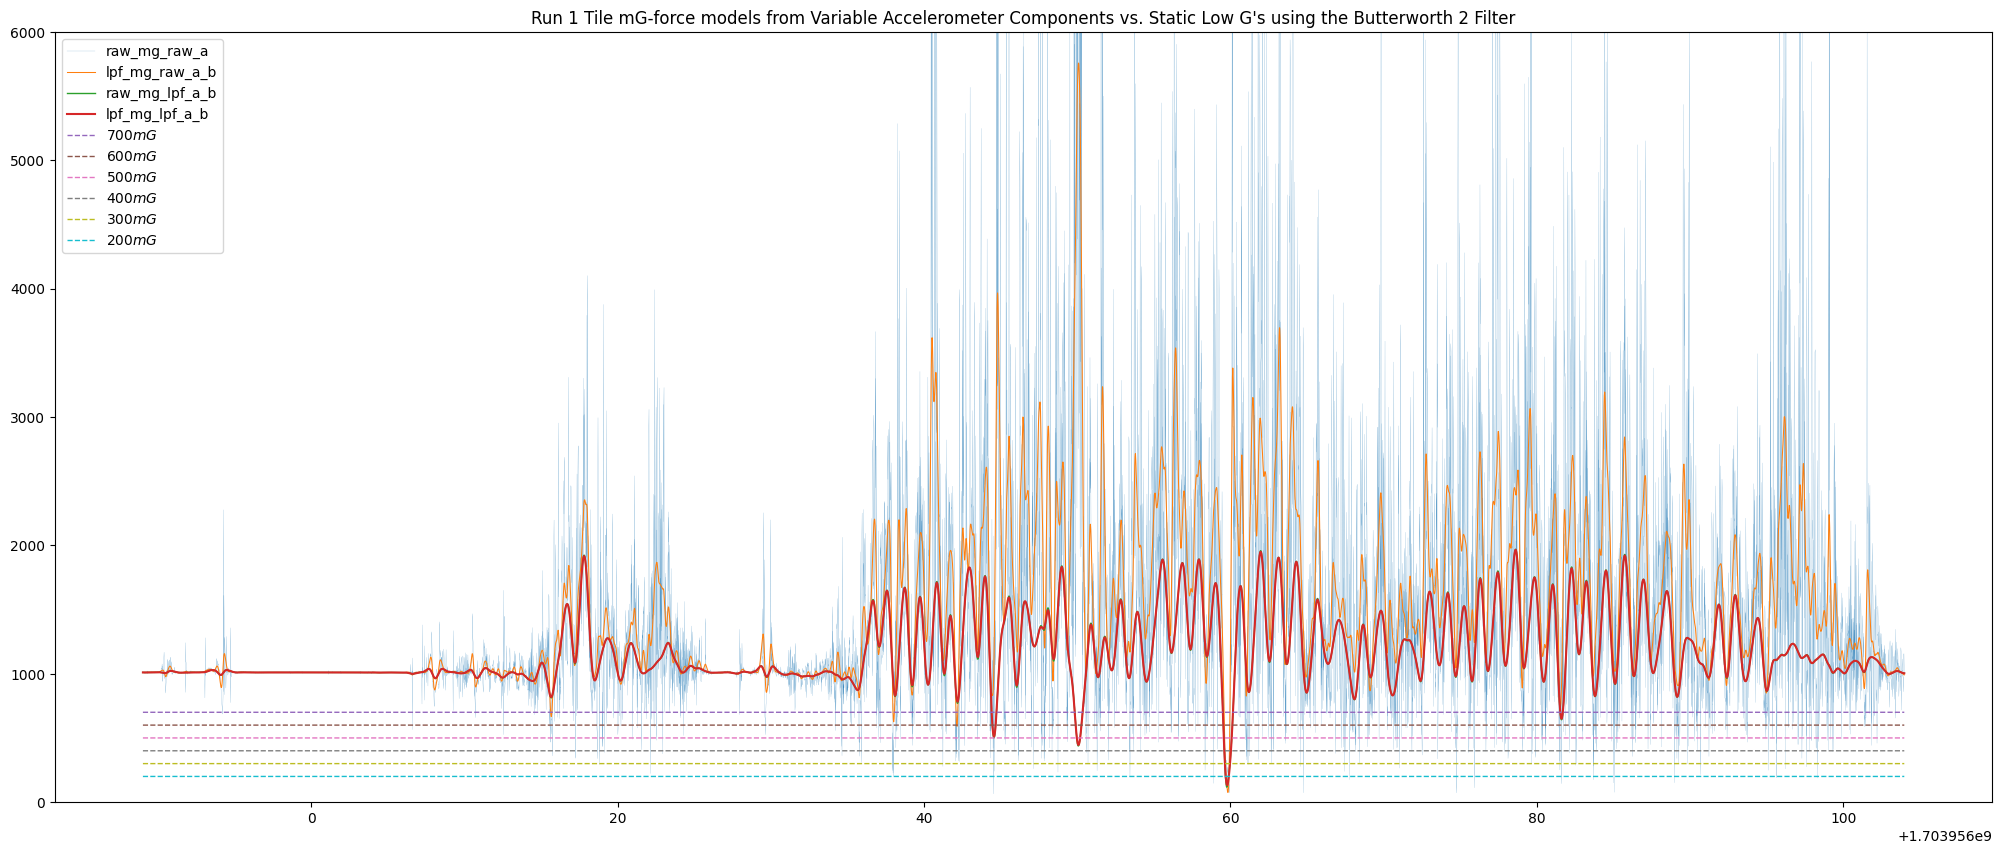

min raw_mg_raw_a: 71.61703707917552 at index: 7092
min lpf_mg_raw_a_b: 75.10988848403787 at index: 7083
min raw_mg_lpf_a_b: 116.40436950035001 at index: 7076
min lpf_mg_lpf_a_b: 131.896856895217 at index: 7078


In [12]:
plt.rc('lines', linewidth=1)
_, ax = plt.subplots(figsize=(25, 10))
ax.plot(run1.time, raw_mg_raw_a, label='raw_mg_raw_a', lw=0.1)
ax.plot(run1.time, lpf_mg_raw_a_b, label='lpf_mg_raw_a_b', lw=0.75)
ax.plot(run1.time, raw_mg_lpf_a_b, label='raw_mg_lpf_a_b')
ax.plot(run1.time, lpf_mg_lpf_a_b, label='lpf_mg_lpf_a_b', lw=1.5)
ax.plot(run1.time, [700 for _ in run1.time], '--', label=r'$700mG$')
ax.plot(run1.time, [600 for _ in run1.time], '--', label=r'$600mG$')
ax.plot(run1.time, [500 for _ in run1.time], '--', label=r'$500mG$')
ax.plot(run1.time, [400 for _ in run1.time], '--', label=r'$400mG$')
ax.plot(run1.time, [300 for _ in run1.time], '--', label=r'$300mG$')
ax.plot(run1.time, [200 for _ in run1.time], '--', label=r'$200mG$')
ax.set_title('Run 1 Tile mG-force models from Variable Accelerometer Components vs. Static Low G\'s using the Butterworth 2 Filter', wrap=True)
plt.legend()
plt.ylim(0, 6000)
plt.show()

print('min raw_mg_raw_a:', min(raw_mg_raw_a[7050:7150]), 'at index:', minIndex(raw_mg_raw_a, [7050, 7150]))
print('min lpf_mg_raw_a_b:', min(lpf_mg_raw_a_b), 'at index:', minIndex(lpf_mg_raw_a_b))
print('min raw_mg_lpf_a_b:', min(raw_mg_lpf_a_b), 'at index:', minIndex(raw_mg_lpf_a_b))
print('min lpf_mg_lpf_a_b:', min(lpf_mg_lpf_a_b), 'at index:', minIndex(lpf_mg_lpf_a_b))

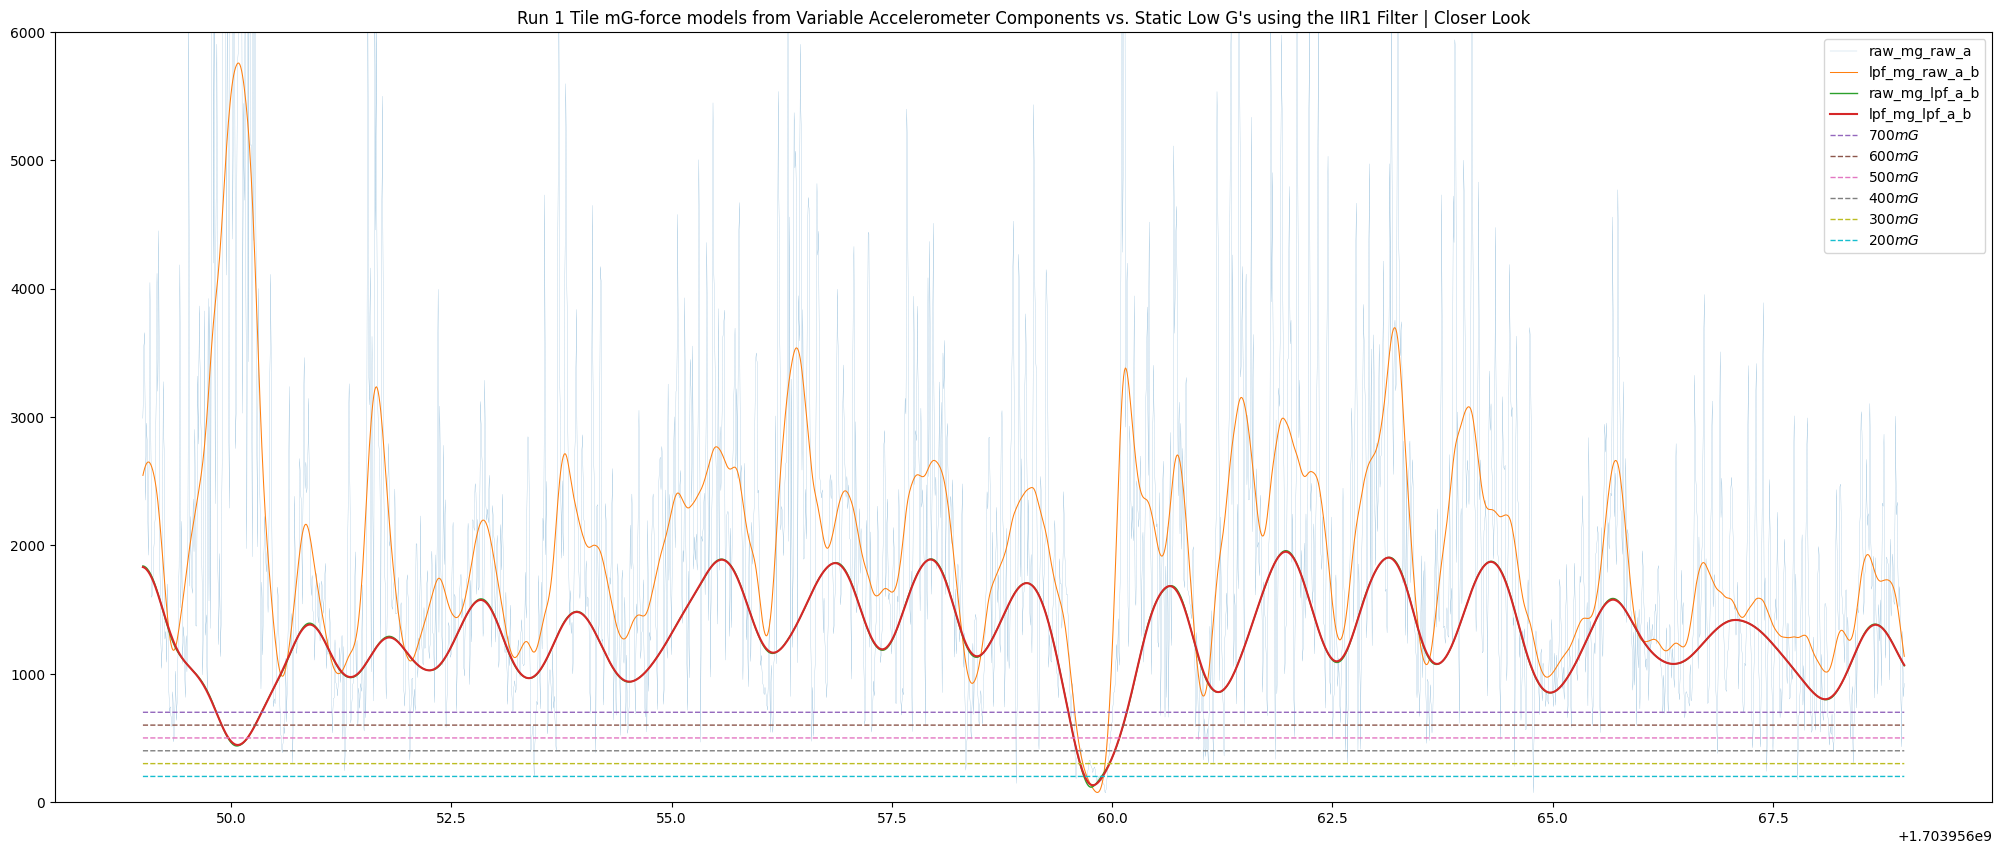

In [13]:
plt.rc('lines', linewidth=1)
_, ax = plt.subplots(figsize=(25, 10))
ax.plot(run1.time[min_r[0]:min_r[1]], raw_mg_raw_a[min_r[0]:min_r[1]], label='raw_mg_raw_a', lw=0.1)
ax.plot(run1.time[min_r[0]:min_r[1]], lpf_mg_raw_a_b[min_r[0]:min_r[1]], label='lpf_mg_raw_a_b', lw=0.75)
ax.plot(run1.time[min_r[0]:min_r[1]], raw_mg_lpf_a_b[min_r[0]:min_r[1]], label='raw_mg_lpf_a_b')
ax.plot(run1.time[min_r[0]:min_r[1]], lpf_mg_lpf_a_b[min_r[0]:min_r[1]], label='lpf_mg_lpf_a_b', lw=1.5)
ax.plot(run1.time[min_r[0]:min_r[1]], [700 for _ in run1.time[min_r[0]:min_r[1]]], '--', label=r'$700mG$')
ax.plot(run1.time[min_r[0]:min_r[1]], [600 for _ in run1.time[min_r[0]:min_r[1]]], '--', label=r'$600mG$')
ax.plot(run1.time[min_r[0]:min_r[1]], [500 for _ in run1.time[min_r[0]:min_r[1]]], '--', label=r'$500mG$')
ax.plot(run1.time[min_r[0]:min_r[1]], [400 for _ in run1.time[min_r[0]:min_r[1]]], '--', label=r'$400mG$')
ax.plot(run1.time[min_r[0]:min_r[1]], [300 for _ in run1.time[min_r[0]:min_r[1]]], '--', label=r'$300mG$')
ax.plot(run1.time[min_r[0]:min_r[1]], [200 for _ in run1.time[min_r[0]:min_r[1]]], '--', label=r'$200mG$')
ax.set_title('Run 1 Tile mG-force models from Variable Accelerometer Components vs. Static Low G\'s using the IIR1 Filter | Closer Look', wrap=True)
plt.legend()
plt.ylim(0, 6000)
plt.show()

### Confirming the Selection of the G-force Signal

Plotting by levels of noise, this shows that the double-filtered mG-force signal clearly shows points of low and high G's. However, quick points of low G's, as seen by jumps, aren't as amplified and therefore harder to detect with a static threshold. Since it's unkown at this point, create a method that determines all  types of un/filtered G-forces for post selection.

The Butterworth filtfilt results have more accurate timing with the original- specifically the ones where it's just the accelerometer signals filtered and G-forces unfiltered. Therefore, the filter that best represents the G-forces will be `raw_mg_lpf_a_b`!

Using mean and std is prone to error, especially with different levels of skiing. If a run is slow and observes G-forces hovering around 1, then small deviations/hops between turns may trigger jump detections due to a low std. A static threshold may be a better option across multiple users, and will be explored more in the jump identification notebook.

## Lowpass Filter Design for G-force

At this point, the same lpf properties have been used between the accelerometer and G-force signals. G-forces based on filtered accelerometer data are far less noisy, and should use a different `fc`.

The signal should be able to be used to identify:

- true values of G-force by limiting the reduction of signal amplitude/magnitude
- points of quick low G's, signifying jumps
- points of cyclic higher G's compared to baseline, signifying turns
- large G's, not necessarily quick (>10Hz), signifying hard stops

In [14]:
lpf_mg_10 = length(run1.ax_lpf(10/100, 'butter2'), run1.ay_lpf(10/100, 'butter2'), run1.az_lpf(10/100, 'butter2'))
lpf_mg_09 = length(run1.ax_lpf(9/100, 'butter2'), run1.ay_lpf(9/100, 'butter2'), run1.az_lpf(9/100, 'butter2'))
lpf_mg_08 = length(run1.ax_lpf(8/100, 'butter2'), run1.ay_lpf(8/100, 'butter2'), run1.az_lpf(8/100, 'butter2'))
lpf_mg_07 = length(run1.ax_lpf(7/100, 'butter2'), run1.ay_lpf(7/100, 'butter2'), run1.az_lpf(7/100, 'butter2'))
lpf_mg_06 = length(run1.ax_lpf(6/100, 'butter2'), run1.ay_lpf(6/100, 'butter2'), run1.az_lpf(6/100, 'butter2'))
lpf_mg_05 = length(run1.ax_lpf(5/100, 'butter2'), run1.ay_lpf(5/100, 'butter2'), run1.az_lpf(5/100, 'butter2'))
lpf_mg_04 = length(run1.ax_lpf(4/100, 'butter2'), run1.ay_lpf(4/100, 'butter2'), run1.az_lpf(4/100, 'butter2'))
lpf_mg_03 = length(run1.ax_lpf(3/100, 'butter2'), run1.ay_lpf(3/100, 'butter2'), run1.az_lpf(3/100, 'butter2'))
lpf_mg_02 = length(run1.ax_lpf(2/100, 'butter2'), run1.ay_lpf(2/100, 'butter2'), run1.az_lpf(2/100, 'butter2'))
lpf_mg_01 = length(run1.ax_lpf(1/100, 'butter2'), run1.ay_lpf(1/100, 'butter2'), run1.az_lpf(1/100, 'butter2'))

In [15]:
def mgStaticGLines(ax, t):
    ax.plot(t, [2300 for _ in t], '--')
    ax.plot(t, [2200 for _ in t], '--')
    ax.plot(t, [2100 for _ in t], '--')
    ax.plot(t, [2000 for _ in t], '--')
    ax.plot(t, [1900 for _ in t], '--')
    ax.plot(t, [1800 for _ in t], '--', label=r'$1800mG$')
    ax.plot(t, [700 for _ in t], '--', label=r'$700mG$')
    ax.plot(t, [600 for _ in t], '--')
    ax.plot(t, [500 for _ in t], '--')
    ax.plot(t, [400 for _ in t], '--')
    ax.plot(t, [300 for _ in t], '--')
    ax.plot(t, [200 for _ in t], '--')
    ax.legend()

### Plotting with A50 Ground Truth

Plotted alongside the computed mG's from the A50 velocity signals, at a static turn radius of 25m. Added 1G to accomidate for the holistic measurements of the accelerometer, note that these are all displayed at 1Hz, while the G-forces are calculated based on the accelerometer's 100Hz. Therefore, assume that all acceleration peaks shown by the Tile should be above the a50.

In [16]:
# qualitative shift for best alignment
a50_t = [t + 11 for t in a50_2023_12_30[0].time]
a50_mgs = [(1 + gFromVelAndR(v, 25)) * 1000 for v in a50_2023_12_30[0].vel]
print(max(a50_2023_12_30[0].vel))

14.75


In [17]:
def plotFcGforceAnalysis(t, xs, truth_t, truth_a):
    plt.rc('lines', linewidth=1)
    _, ax = plt.subplots(10, sharex=True, figsize=(25, 35))

    ax[0].plot(t, xs[0])
    ax[0].plot(truth_t, truth_a, label='peak A50 mGs')
    mgStaticGLines(ax[0], t)
    ax[0].set_title('Run 1 Tile 10Hz LPF mG-forces vs. Peak Centripital Gs based on A50 Velocity', wrap=True)

    ax[1].plot(t, xs[1])
    ax[1].plot(truth_t, truth_a, label='peak A50 mGs')
    mgStaticGLines(ax[1], t)
    ax[1].set_title('Run 1 Tile 9Hz LPF mG-forces vs. Peak Centripital Gs based on A50 Velocity', wrap=True)

    ax[2].plot(t, xs[2])
    ax[2].plot(truth_t, truth_a, label='peak A50 mGs')
    mgStaticGLines(ax[2], t)
    ax[2].set_title('Run 1 Tile 8Hz LPF mG-forces vs. Peak Centripital Gs based on A50 Velocity', wrap=True)

    ax[3].plot(t, xs[3])
    ax[3].plot(truth_t, truth_a, label='peak A50 mGs')
    mgStaticGLines(ax[3], t)
    ax[3].set_title('Run 1 Tile 7Hz LPF mG-forces vs. Peak Centripital Gs based on A50 Velocity', wrap=True)

    ax[4].plot(t, xs[4])
    ax[4].plot(truth_t, truth_a, label='peak A50 mGs')
    mgStaticGLines(ax[4], t)
    ax[4].set_title('Run 1 Tile 6Hz LPF mG-forces vs. Peak Centripital Gs based on A50 Velocity', wrap=True)

    ax[5].plot(t, xs[5])
    ax[5].plot(truth_t, truth_a, label='peak A50 mGs')
    mgStaticGLines(ax[5], t)
    ax[5].set_title('Run 1 Tile 5Hz LPF mG-forces vs. Peak Centripital Gs based on A50 Velocity', wrap=True)

    ax[6].plot(t, xs[6])
    ax[6].plot(truth_t, truth_a, label='peak A50 mGs')
    mgStaticGLines(ax[6], t)
    ax[6].set_title('Run 1 Tile 4Hz LPF mG-forces vs. Peak Centripital Gs based on A50 Velocity', wrap=True)

    ax[7].plot(t, xs[7])
    ax[7].plot(truth_t, truth_a, label='peak A50 mGs')
    mgStaticGLines(ax[7], t)
    ax[7].set_title('Run 1 Tile 3Hz LPF mG-forces vs. Peak Centripital Gs based on A50 Velocity', wrap=True)

    ax[8].plot(t, xs[8])
    ax[8].plot(truth_t, truth_a, label='peak A50 mGs')
    mgStaticGLines(ax[8], t)
    ax[8].set_title('Run 1 Tile 2Hz LPF mG-forces vs. Peak Centripital Gs based on A50 Velocity', wrap=True)

    ax[9].plot(t, xs[9])
    ax[9].plot(truth_t, truth_a, label='peak A50 mGs')
    mgStaticGLines(ax[9], t)
    ax[9].set_title('Run 1 Tile 1Hz LPF mG-forces vs. Peak Centripital Gs based on A50 Velocity', wrap=True)

    plt.tight_layout()
    plt.show()

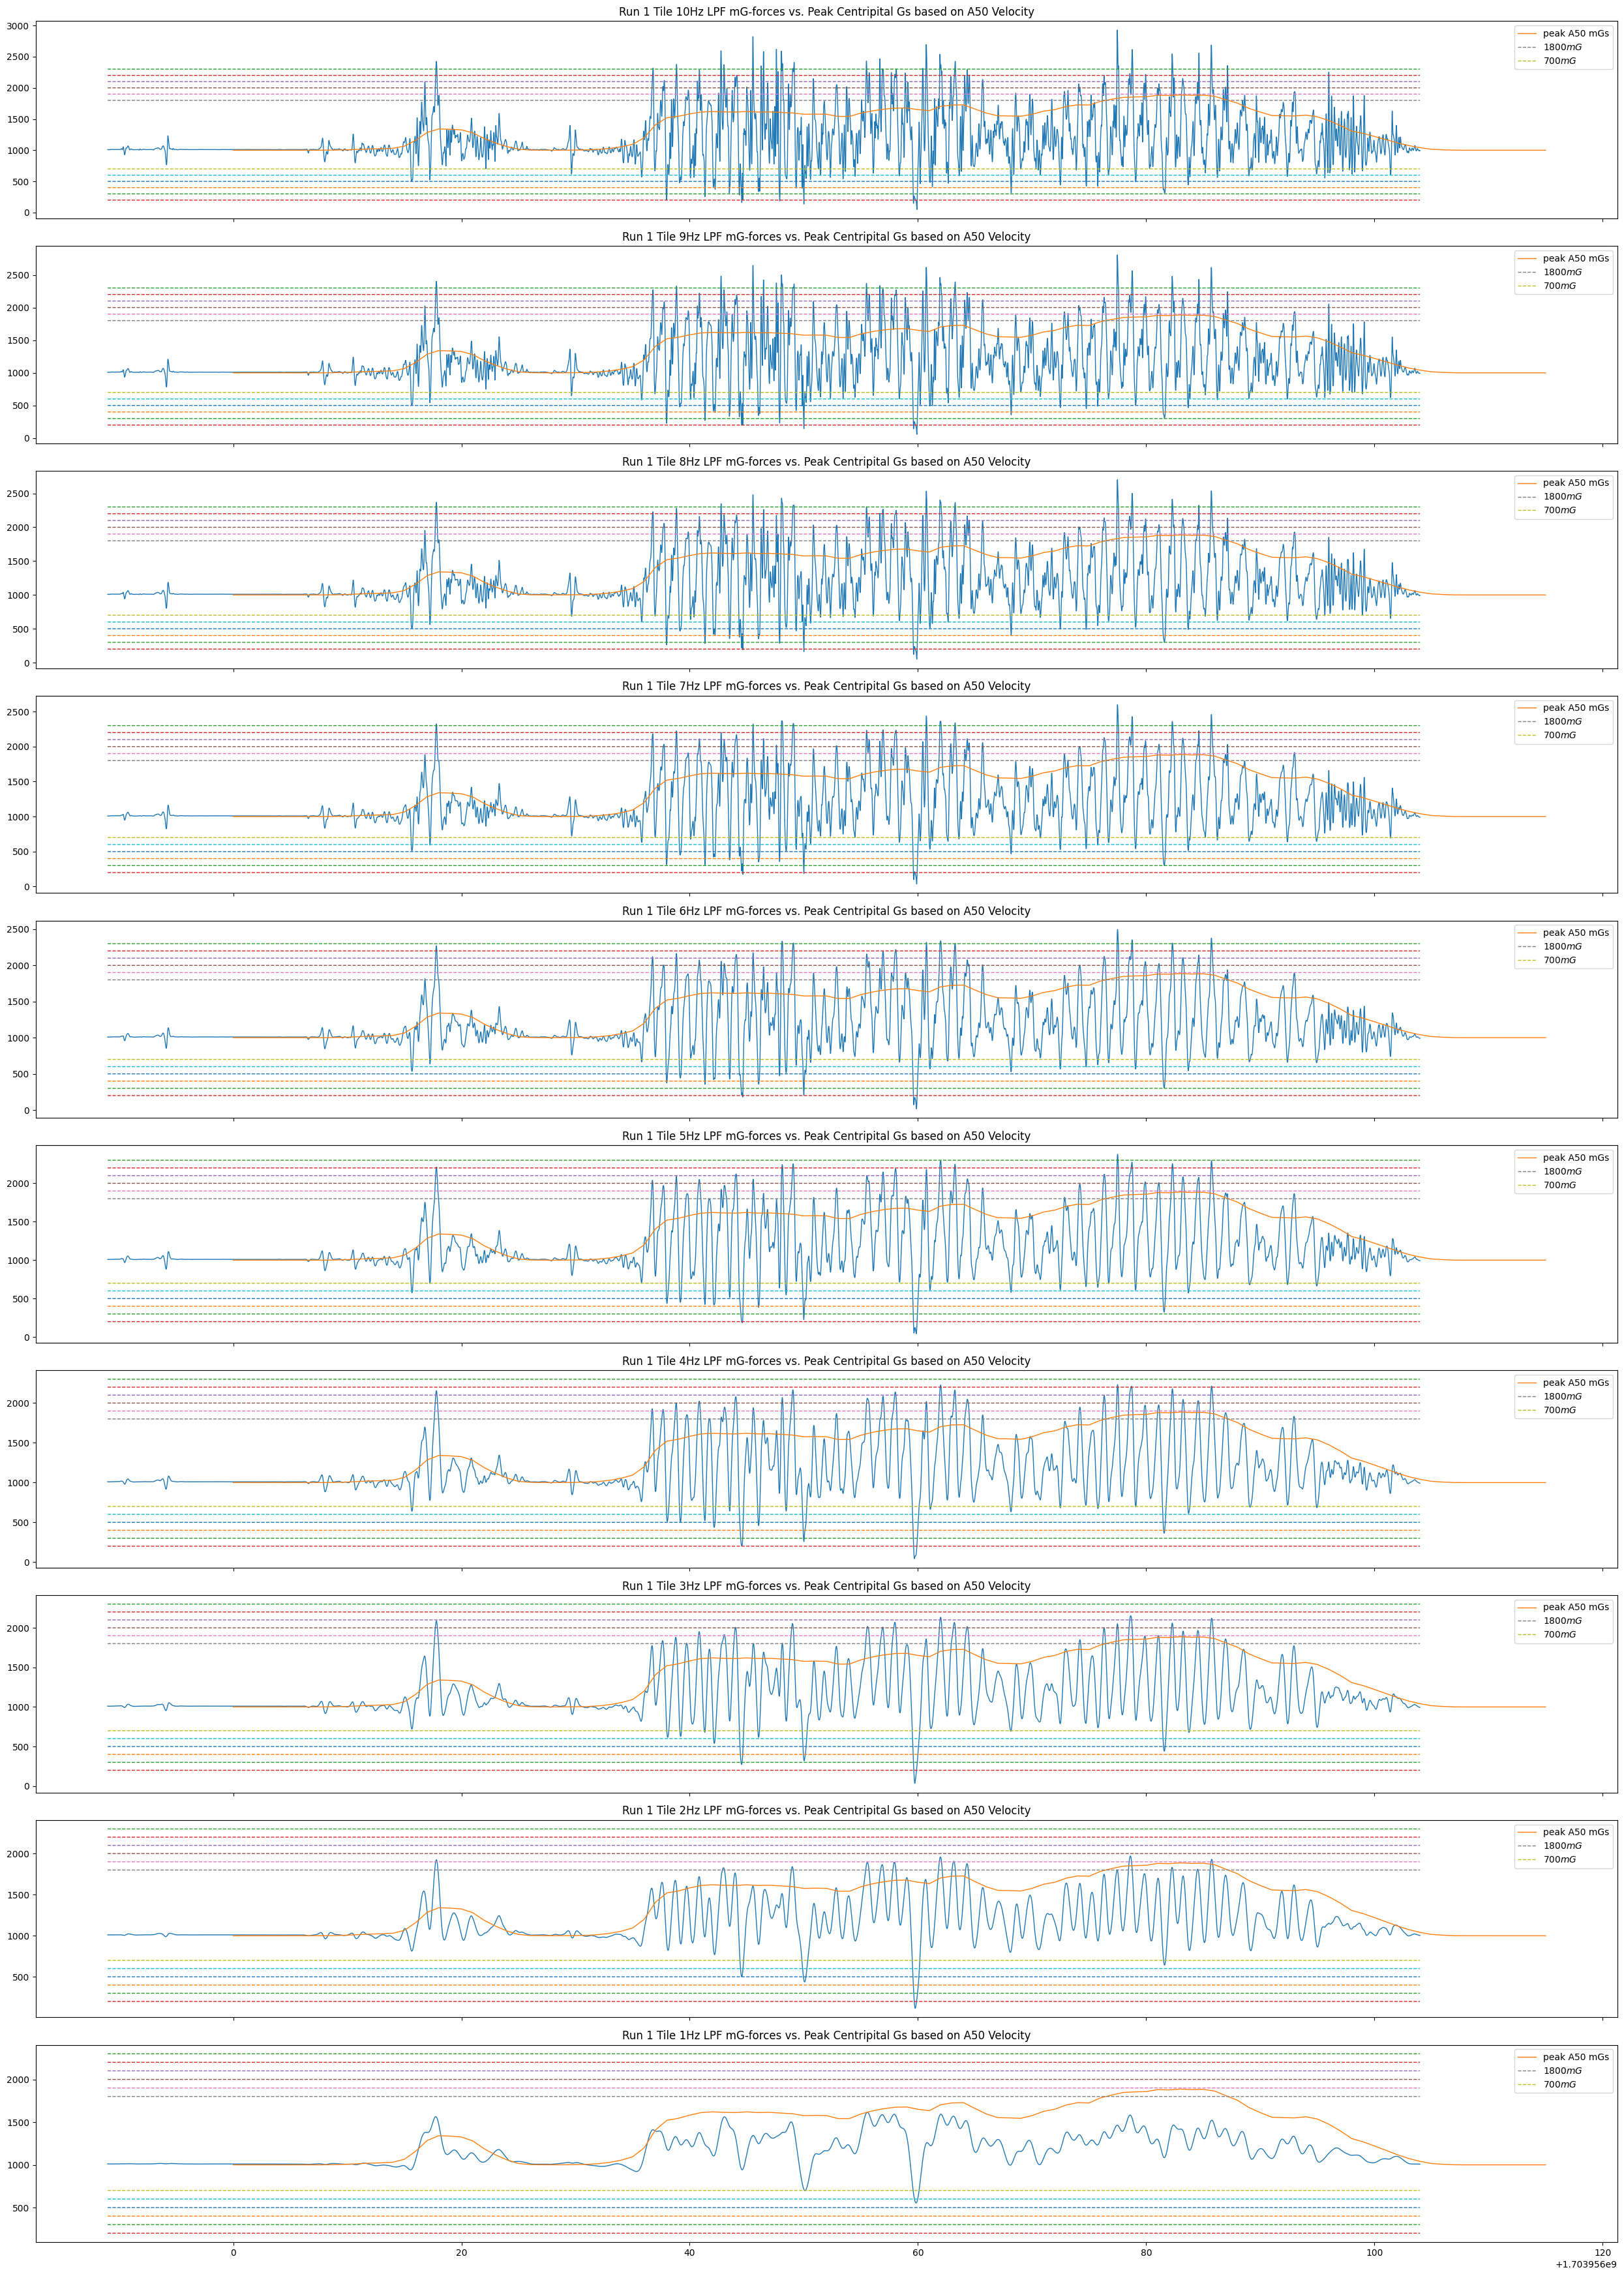

In [18]:
plotFcGforceAnalysis(
    run1.time,
    [
        lpf_mg_10,
        lpf_mg_09,
        lpf_mg_08,
        lpf_mg_07,
        lpf_mg_06,
        lpf_mg_05,
        lpf_mg_04,
        lpf_mg_03,
        lpf_mg_02,
        lpf_mg_01
    ],
    a50_t,
    a50_mgs
)

### Conclusion

Based on these results, the `fc = 15Hz` appears to be the best cutoff frequency that still shows:

- peak G-force of ~1.1G for centripital force. Note that a 30m turn at 18m/s is ~1.1G
- low points still discernable
- most higher sampling peaks met, if not exceeded the lower sampling extrapolated a50 G's
- relatively smooth G-force curves, can discern cyclic points of turning
- no data for hard stops, but given those are slower movements than jumps, they'd be visible

The lower a50 sampling rate for velocity measurement is also prone to error and misrepresentation due to lost amplitudes that occur at higher frequencies. The top speed of this run was `14.75m/s`, which provides a max centripital G-force of `G = 0.89` based on a `r=25m`. Despite the small 0.2G error, `fc = 15Hz` strikes a good balance between capturing realistic centripital force peaks and brief moments of low G's .

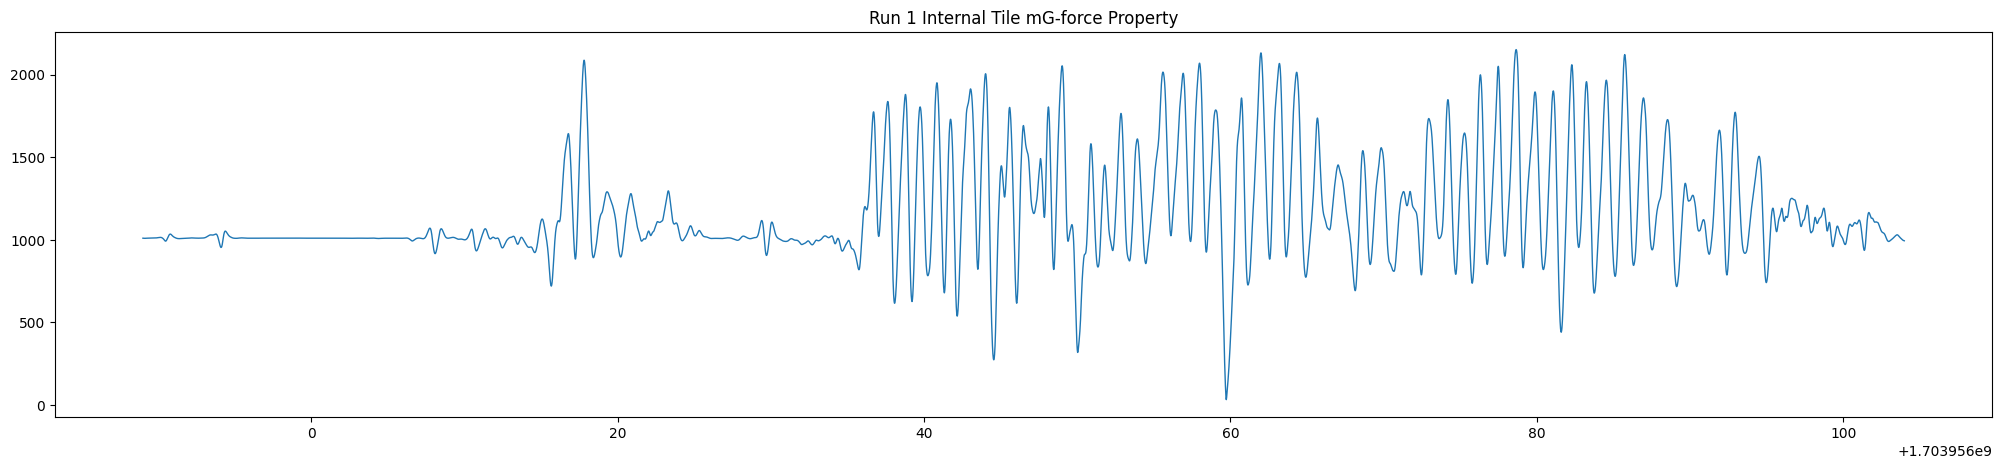

In [19]:
plt.rc('lines', linewidth=1)
_, ax = plt.subplots(figsize=(25, 5))
ax.plot(run1.time, run1.mG_lpf(ftype='butter2'))
ax.set_title('Run 1 Internal Tile mG-force Property', wrap=True)
plt.show()